In [41]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import os
import os
import statsmodels.api as sm
from IPython.display import display, HTML
from concurrent.futures import ThreadPoolExecutor
from IPython.display import display, HTML
import sys
from collections import Counter


# ML Functions
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

# NLP functions
from datasets import load_dataset
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
from wordcloud import WordCloud
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import docx2txt
import requests
import subprocess
from tabulate import tabulate
# from textblob import TextBlob
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix
from langdetect import detect
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
#!python -m spacy download en_core_web_sm
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
sp = spacy.load('en_core_web_sm')

porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

import warnings
# Ignore SettingWithCopyWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/user/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Utils

In [42]:
# Additional functions
def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()
    
def tokenize(text, modulation):
    if modulation < 2:
        tokens = re.split(r'\W+', text)
        stems = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            lowers=abbr_or_lower(token)
            if lowers not in stop_words:
                if re.search('[a-zA-Z]', lowers):
                    if modulation==0:
                        stems.append(lowers)
                    if modulation==1:
                        stems.append(porter.stem(lowers))
    else:
        sp_text=sp(text)
        stems = []
        lemmatized_text=[]
        for word in sp_text:
            lemmatized_text.append(word.lemma_)
        stems = [abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)]
    return " ".join(stems)

def vectorize(tokens, vocab):
    vector=[]
    for w in vocab:
        vector.append(tokens.count(w))
    return vector

### Importing data

In [43]:
path = './data/job_postings/hannes_jobs.csv'
data = pd.read_csv(path, sep='|')
df = pd.DataFrame(data)

Some of the deescriptions are in languages different from english, we will filter them out. The methodology is not completely robust, as descriptions with mixed languages will remain in the data, but will be a very small amount that will not be influential on the results.

In [44]:
def filter_and_translate_description(row):
    # Detect the language of the description
    language = detect(row['description'])

    # Check if the language is English ('en')
    if language == 'en':
        return row
    else:
        return None  # Skip non-English descriptions

filtered_rows = [filter_and_translate_description(row) for _, row in df.iterrows()]

# Drop rows where the detected language is not English
df = pd.DataFrame([row for row in filtered_rows if row is not None])
print(df.shape)

(1705, 7)


## Parsing descriptions

### Preprocessing

For now we will just apply lowercasing, there will be further preprocessing in following steps.

In [45]:
def lowercase_text(text):
    return text.lower()

df['processed_text'] = df['description'].apply(lowercase_text)

In the Job descriptions the corpus is usually composed by a description of the company, the body which includes the content of the job (what we are most interested in) and a final section including benefits or additional information.

We will extract the interesting information using a regex pattern that will cut the initial and the final section. This will inevitably decrease the number of available descriptions, but will ensure robust analysis which for our purpose is what we are mostly looking for.

The following variables contain the expressions to match to achieve the predefined goal. A regex pattern is then defined and applied to the descriptions.

new rules applied that decreased the number of matches by around 30 percent: 

'we are proud' ,'our mission' ,'proud to be', '@' , 'we truly believe' , 'what you\'ll benefit',

In [46]:
words_to_include = ['what you can expect in this role','what you should bring','in this role you will', 'the work will require','you are going to','what you\'ll do','what you will do','what will you do', 'what we\'re looking for', 'we are looking for', 'we\'re looking for', 'what we are looking for', 'typical day in role', 'what you\'ll be doing', 'you will be working', 'you\'ll be working', 'job details', 'responsibilities', 'your responsibilities','key responsibilities', 'main responsibilities', 'key qualifications','minimum qualifications','minimum requirements' ,'your profile', 'your role', 'about the job', 'about you', 'about the opportunity','about this opportunity', 'your mission', 'we are seeking', 'we offer', 'tasks associated to this job']
words_to_exclude = ['we are proud' ,'our mission' ,'proud to be', '@' , 'we truly believe' , 'what you\'ll benefit','for more information', 'for more info', 'share this', 'share this job', 'discover our', 'follow us', 'we welcome applicants', 'if you think you have', 'we believe', 'we do not discriminate', 'discriminate', 'equal opportunity', 'additional information', 'equal employment opportunity', 'find out more about','find out more', 'build a better future', 'want to know more', 'know more', 'who we are', 'what do we offer', 'what we offer','for enquiry', 'about us', 'affirmative action', 'what you’ll find', 'data protection policy', 'personal data protection policy', 'personal data protection', 'if you think you', 'we offer you', 'we invite you','what you will have', 'what you will get', 'flexible hours', 'multicultural work environment', 'race', 'color', 'religion', 'sex', 'disability', 'sexual orientation', 'to submit your application', 'benefits', 'we are looking forward', 'apply now', 'insurance', 'location', 'where you will work', 'where it will be', 'if you are']

# Constructing a regex pattern to capture content after the first appearance of any specified word
regex_pattern = f"(?:{'|'.join(map(re.escape, words_to_include))})(.*?)(?:$)"

In [47]:
# Applying the regex pattern to extract job content only from the first appearance of a specified word
def extract_job_content(description):
    match = re.search(regex_pattern, description, re.IGNORECASE | re.DOTALL)
    return match.group(1).strip() if match else np.nan

# Applying the extraction function to the DataFrame
df_new = df.copy()
df_new['job_content'] = df_new['processed_text'].apply(extract_job_content)

# Excluding words
exclude_pattern = f"({'|'.join(map(re.escape, words_to_exclude))})(.*?$)"

# Applying the regex pattern to exclude content after specified words
def exclude_content(description):
    if pd.notna(description):  # Check for non-NaN values
        return re.sub(exclude_pattern, '', description, flags=re.IGNORECASE | re.DOTALL)
    else:
        return np.nan

df_new['job_content_processed'] = df_new['job_content'].apply(exclude_content)

# Optionally, you can replace empty strings with NaN in the processed column
df_new['job_content_processed'].replace('', np.nan, inplace=True)
print(df_new.shape)

(1705, 10)


To improve the rules in the matcher the data that was not matched will be analyzed to apply some trial and error and improve the matching rules.

In [48]:
df_missing = df_new[df_new['job_content_processed'].isna()]

In [49]:
print(f'Percentage of unmatched descriptions: {round((df_missing.shape[0])/(df_new.shape[0])*100, 2)}%')

Percentage of unmatched descriptions: 19.0%


In [50]:
df_new.shape

(1705, 10)

The missing data in the dataframe with processed descriptions will be dropped.

In [51]:
df_new=df_new.dropna()
df_new.reset_index

<bound method DataFrame.reset_index of                            companies  companies_rating  \
0                                IBM               4.0   
1                           Ericsson               4.2   
2                managementsolutions               3.8   
3                 McKinsey & Company               4.4   
4                 McKinsey & Company               4.4   
...                              ...               ...   
2098                       CME Group               3.9   
2099                       Synchrony               4.2   
2100                        Deloitte               4.0   
2101  Cardinal Intellectual Property               3.8   
2102          Chicago Public Schools               3.3   

                                              job_title     location  \
0                                          Student DATA         Lima   
1                                Data Analyst - Student         Lima   
2                          DATA SCIENCE CONSULTA

# ISSUE: index doesn't reset for some reason

In [52]:
# # Printing an example of a job content
# print(df_new['job_content_processed'][1010])


In [53]:
print(f'The final dataset has {df_new.shape[0]} job descriptions to be processed.')

The final dataset has 1204 job descriptions to be processed.


## Preprocessing

The descriptions were preprocessed using standard practices such as lowercasing (applied precedently), removing stopwords and stemming. 

CONSIDER LEMMATIZING.

In [54]:
# df['processed_text'] = df['description'].apply(lambda x: ' '.join(abbr_or_lower(word) for word in x.split()))
# Remove stopwords
stop_words = set(stopwords.words('english'))
df_new['processed_description'] = df_new['job_content_processed'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Apply stemming
stemmer = PorterStemmer()
df_new['processed_description'] = df_new['processed_description'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

print(df_new['processed_description'])


0       respons soport en cierr de proyecto de deliver...
1       look data analyst - student (industri engineer...
2       key project lead organ data mine & knowledg di...
3       data engin will... partner clients, data owner...
4       data scientist quantumblack expect... respons ...
                              ...                        
2098    highli intellig person desir autonomi explor c...
2099    : account full cycl analyt deliver – ideation,...
2100    include: identifi priorit ai data opportun dri...
2101    critic analyz new method technolog appli scala...
2102    : ensur data qualiti integr across offic adher...
Name: processed_description, Length: 1204, dtype: object


## Skills extraction

Every job description has some specific skills that are required or requested. Depending on the job position these skills will change. Our objective is again to make clusters of job postings based on their description raher than the job titles. This practice will be enhanced by selecting the most required skills for each of the job clusters.

To extract the skills we used spacy's Named Entity Recognition. We trained our own model labeling part of our data detecting Hard and Soft skills in the descriptions. The model was then applied to extract the skills from each of the descriptions and stored in two separate columns for Hard and Soft skills.

The following data was used for training (very large content in following cell):

In [55]:
TRAIN_DATA = {"classes":["SOFT_SKILL","HARD_SKILL"],"annotations":[["\"Seeking a data scientist proficient in Python and machine learning.\"",{"entities":[[40,46,"HARD_SKILL"],[51,67,"HARD_SKILL"]]}],["\"Experience with SQL and data visualization tools like Tableau is required.\"",{"entities":[[17,20,"HARD_SKILL"],[55,62,"HARD_SKILL"]]}],["\"Excellent communication and teamwork skills are essential.\"",{"entities":[[11,24,"SOFT_SKILL"],[29,37,"SOFT_SKILL"]]}],["\"Statistical analysis and mathematical modeling expertise are a plus.\"",{"entities":[[1,21,"HARD_SKILL"],[26,47,"HARD_SKILL"]]}],["\"Proficiency in programming languages such as R and Java is required for data analysis.\"",{"entities":[[46,47,"HARD_SKILL"],[52,56,"HARD_SKILL"]]}],["\"Strong problem-solving and critical thinking abilities are crucial for this data science role.\"",{"entities":[[8,23,"SOFT_SKILL"],[28,45,"SOFT_SKILL"]]}],["\"Hands-on experience with big data technologies, such as Hadoop and Spark, is a plus.\"",{"entities":[[26,34,"HARD_SKILL"],[57,63,"HARD_SKILL"],[68,73,"HARD_SKILL"]]}],["\"Ability to work with cross-functional teams and communicate findings to non-technical stakeholders.\"",{"entities":[[12,44,"SOFT_SKILL"],[49,99,"SOFT_SKILL"]]}],["\"Familiarity with machine learning algorithms and model deployment is desirable.\"",{"entities":[[18,45,"HARD_SKILL"],[50,66,"HARD_SKILL"]]}],["\"Experience in data cleaning, preprocessing, and feature engineering is a prerequisite.\"",{"entities":[[15,28,"HARD_SKILL"],[30,43,"HARD_SKILL"],[49,68,"HARD_SKILL"]]}],["\"Adaptability and a continuous learning mindset are essential for keeping up with evolving data science technologies.\"",{"entities":[[20,47,"SOFT_SKILL"],[66,116,"SOFT_SKILL"]]}],["\"Knowledge of statistical tests and experimental design is necessary for drawing meaningful insights from data.\"",{"entities":[[14,31,"HARD_SKILL"],[36,55,"HARD_SKILL"],[73,100,"HARD_SKILL"]]}],["\"Experience with cloud computing platforms like AWS or Azure is a valuable asset.\", ",{"entities":[[17,32,"HARD_SKILL"],[48,51,"HARD_SKILL"],[55,60,"HARD_SKILL"]]}],["",{"entities":[]}],["\"Attention to detail and a high level of accuracy are important when working with large datasets.\"",{"entities":[[1,20,"SOFT_SKILL"],[41,49,"SOFT_SKILL"]]}],["\"Proficient in using data visualization libraries like Matplotlib and Seaborn for presenting insights.\"",{"entities":[[55,65,"HARD_SKILL"],[70,77,"HARD_SKILL"]]}],["\"Collaborative problem-solving and effective communication with team members are key aspects of this role.\"",{"entities":[[15,30,"SOFT_SKILL"],[35,58,"SOFT_SKILL"]]}],["\"Experience with natural language processing (NLP) and text mining techniques is highly desirable.\"",{"entities":[[17,44,"HARD_SKILL"],[46,49,"HARD_SKILL"],[55,66,"HARD_SKILL"]]}],["\"Leadership skills and the ability to mentor junior team members are important for career growth.\"",{"entities":[[1,11,"SOFT_SKILL"],[27,44,"SOFT_SKILL"]]}],["\"In-depth knowledge of databases, including SQL and NoSQL, is a fundamental requirement for this position.\"",{"entities":[[23,32,"HARD_SKILL"],[44,47,"HARD_SKILL"],[52,57,"HARD_SKILL"]]}],["\"Adaptability to new programming languages and frameworks as the data science field evolves.\"",{"entities":[]}],["\"Demonstrated expertise in feature selection and dimensionality reduction techniques is a must.\"",{"entities":[[27,44,"HARD_SKILL"],[49,73,"HARD_SKILL"]]}],["\"Adaptability to new tools and technologies, along with a curiosity for exploring innovative solutions.\"",{"entities":[[1,13,"SOFT_SKILL"],[58,67,"SOFT_SKILL"],[72,102,"SOFT_SKILL"]]}],["\"Knowledge of A/B testing methodologies and experimental design for data-driven decision-making.\"",{"entities":[[14,25,"HARD_SKILL"],[44,63,"HARD_SKILL"]]}],["\"Experience with version control systems such as Git and collaborative coding practices is essential.\"",{"entities":[[49,52,"HARD_SKILL"]]}],["\"Effective time management and prioritization skills for handling multiple data science projects concurrently.\"",{"entities":[[11,26,"SOFT_SKILL"],[31,45,"SOFT_SKILL"],[66,109,"SOFT_SKILL"]]}],["\"Knowledge of optimization algorithms and the ability to fine-tune models for better performance.\"",{"entities":[[14,37,"HARD_SKILL"],[57,73,"HARD_SKILL"]]}],["\"Interpersonal skills for building strong relationships with stakeholders and understanding their data needs.\"",{"entities":[[1,14,"SOFT_SKILL"],[26,55,"SOFT_SKILL"],[78,108,"SOFT_SKILL"]]}],["\"Experience with containerization technologies like Docker and orchestration tools such as Kubernetes.\"",{"entities":[[17,46,"HARD_SKILL"],[52,58,"HARD_SKILL"],[63,82,"HARD_SKILL"],[91,101,"HARD_SKILL"]]}],["\"Strong analytical skills and the ability to translate business questions into data-driven analyses.\"",{"entities":[[8,25,"SOFT_SKILL"],[34,73,"SOFT_SKILL"]]}],["\"Familiarity with data ethics and privacy considerations in handling sensitive and confidential information.\"",{"entities":[]}],["\"Effective presentation skills for communicating complex data findings to both technical and non-technical audiences.\"",{"entities":[[11,30,"SOFT_SKILL"],[35,70,"SOFT_SKILL"]]}],["\"Knowledge of deep learning frameworks like TensorFlow and PyTorch for advanced model development.\"",{"entities":[[14,27,"HARD_SKILL"],[44,54,"HARD_SKILL"],[59,70,"HARD_SKILL"]]}],["\"Ability to work in a fast-paced environment and deliver high-quality results under tight deadlines.\"",{"entities":[[22,44,"SOFT_SKILL"],[57,77,"SOFT_SKILL"]]}],["\"Experience in designing and implementing ETL pipelines for efficient data processing and analysis.\"",{"entities":[[42,55,"HARD_SKILL"],[70,98,"HARD_SKILL"]]}],["\"Effective problem-solving skills and the ability to troubleshoot data-related issues independently.\"",{"entities":[[11,26,"SOFT_SKILL"],[42,65,"SOFT_SKILL"]]}],["\"Knowledge of Bayesian statistics and probabilistic modeling for uncertainty quantification.\",",{"entities":[[14,33,"HARD_SKILL"],[38,60,"HARD_SKILL"],[65,92,"HARD_SKILL"]]}],["\"Proactive communication and regular updates with team members for seamless collaboration on projects.\"",{"entities":[[11,24,"SOFT_SKILL"],[29,44,"SOFT_SKILL"],[76,89,"SOFT_SKILL"]]}],["\"Experience with data warehousing solutions like Snowflake and Redshift for scalable data storage.\"",{"entities":[[17,33,"HARD_SKILL"],[49,58,"HARD_SKILL"],[63,75,"HARD_SKILL"]]}],["\"Strong organizational skills and attention to detail in data documentation and code commenting.",{"entities":[[8,22,"SOFT_SKILL"],[34,53,"SOFT_SKILL"],[57,75,"SOFT_SKILL"],[80,95,"SOFT_SKILL"]]}],["\"Knowledge of ensemble learning techniques and the ability to combine multiple models for improved accuracy.\"",{"entities":[[14,31,"HARD_SKILL"],[62,85,"HARD_SKILL"]]}],["\"Effective leadership and mentoring skills for guiding junior team members in their career development.\"",{"entities":[[11,21,"SOFT_SKILL"],[26,35,"SOFT_SKILL"]]}],["\"Experience with data streaming technologies like Apache Kafka for real-time data processing.\"",{"entities":[[17,31,"HARD_SKILL"],[50,56,"HARD_SKILL"],[57,62,"HARD_SKILL"],[67,92,"HARD_SKILL"]]}],["\"Strong business acumen and the ability to translate data insights into actionable business strategies.\"",{"entities":[[8,23,"SOFT_SKILL"],[32,66,"SOFT_SKILL"]]}],["\"Experience with geospatial data analysis and visualization tools like GeoPandas and Folium.\"",{"entities":[[17,41,"HARD_SKILL"],[46,65,"HARD_SKILL"],[71,80,"HARD_SKILL"],[85,91,"HARD_SKILL"]]}],["\"Effective teamwork skills and collaboration with other departments for cross-functional data projects.\"",{"entities":[[11,19,"SOFT_SKILL"],[31,44,"SOFT_SKILL"]]}],["\"Experience with data anonymization techniques and ensuring compliance with data protection regulations.\"",{"entities":[[17,35,"HARD_SKILL"],[76,103,"HARD_SKILL"]]}],["\"Experience with data engineering tools like Apache Airflow for orchestrating data workflows.\"",{"entities":[[17,33,"HARD_SKILL"],[45,59,"HARD_SKILL"]]}],["\"Strong problem-solving skills and adaptability in handling unstructured and messy data sources.\"",{"entities":[[8,23,"SOFT_SKILL"],[35,47,"SOFT_SKILL"],[51,72,"HARD_SKILL"]]}],["\"Knowledge of time-series databases such as InfluxDB and their application in IoT data analytics.\"",{"entities":[[14,35,"HARD_SKILL"],[44,52,"HARD_SKILL"],[78,96,"HARD_SKILL"]]}],["\"Effective collaboration with domain experts and business stakeholders for defining data requirements.\"",{"entities":[[11,24,"SOFT_SKILL"],[75,101,"SOFT_SKILL"]]}],["\"Experience with cloud-based data warehousing solutions like BigQuery and Snowflake.\"",{"entities":[[17,28,"HARD_SKILL"],[29,45,"HARD_SKILL"],[61,69,"HARD_SKILL"],[74,83,"HARD_SKILL"]]}],["\"Innovative thinking and creativity in designing novel algorithms for specific data challenges.\"",{"entities":[[1,20,"SOFT_SKILL"],[25,38,"SOFT_SKILL"],[39,65,"HARD_SKILL"]]}],["\"Knowledge of survival analysis techniques and their application in healthcare data analysis.\"",{"entities":[[14,42,"HARD_SKILL"]]}],["\"Effective communication with external clients to understand their data-driven business objectives.\"",{"entities":[[11,24,"SOFT_SKILL"],[50,98,"SOFT_SKILL"]]}],["\"Experience with probabilistic programming languages like Stan for Bayesian modeling.\"",{"entities":[[17,42,"HARD_SKILL"],[58,62,"HARD_SKILL"],[67,84,"HARD_SKILL"]]}],["\"Adaptability to evolving business requirements and incorporating changes in data science projects.\"",{"entities":[[1,13,"SOFT_SKILL"],[17,47,"SOFT_SKILL"],[52,73,"SOFT_SKILL"]]}],["\"Knowledge of distributed storage systems like HDFS and their integration with data processing frameworks.\"",{"entities":[[14,41,"HARD_SKILL"],[47,51,"HARD_SKILL"]]}],["\"Effective documentation of data science workflows and methodologies for knowledge sharing.\"",{"entities":[[1,24,"SOFT_SKILL"]]}],["\"Experience with anomaly detection techniques and their application in cybersecurity analytics.\"",{"entities":[[17,34,"HARD_SKILL"],[71,94,"HARD_SKILL"]]}],["\"Effective presentation skills for delivering impactful data-driven insights to executive leadership.\"",{"entities":[[11,30,"SOFT_SKILL"],[35,76,"SOFT_SKILL"]]}],["\"Knowledge of meta-learning and the ability to adapt models to new and unseen tasks.\"",{"entities":[[14,27,"HARD_SKILL"],[47,59,"HARD_SKILL"]]}],["\"Effective collaboration with UX/UI designers for integrating data visualizations into user interfaces.\"",{"entities":[[30,35,"HARD_SKILL"],[87,102,"HARD_SKILL"]]}],["\"Experience with real-time data processing frameworks such as Apache Flink and Storm.\"",{"entities":[[17,42,"HARD_SKILL"],[62,74,"HARD_SKILL"],[79,84,"HARD_SKILL"]]}],["\"Strong attention to ethical considerations in data science, ensuring fairness and unbiased models.\"",{"entities":[[8,43,"SOFT_SKILL"],[61,78,"SOFT_SKILL"]]}],["\"Knowledge of quantum computing principles and their potential impact on data science algorithms.\"",{"entities":[[14,31,"HARD_SKILL"],[73,96,"HARD_SKILL"]]}],["\"Effective project management skills for overseeing end-to-end machine learning model deployments.\"",{"entities":[[11,36,"SOFT_SKILL"],[41,79,"SOFT_SKILL"]]}],["\"Experience with natural language understanding (NLU) techniques for processing textual data.\"",{"entities":[[17,47,"HARD_SKILL"],[49,52,"HARD_SKILL"],[69,92,"HARD_SKILL"]]}],["\"Adaptability to interdisciplinary collaboration, working with experts from diverse fields.\"",{"entities":[[17,48,"SOFT_SKILL"]]}],["\"Knowledge of database indexing strategies and optimizing query performance for efficiency.\"",{"entities":[[14,31,"HARD_SKILL"],[47,75,"HARD_SKILL"]]}],["\"Effective communication of statistical results and uncertainties in data-driven decision-making.\"",{"entities":[[11,24,"SOFT_SKILL"]]}],["\"Experience with graph-based machine learning algorithms for social network analysis.\"",{"entities":[[29,45,"HARD_SKILL"]]}],["\"Strong negotiation skills for collaborating with external vendors on data acquisition and partnerships.\"",{"entities":[[8,26,"SOFT_SKILL"]]}],["\"Experience with knowledge graph representation learning for enhancing semantic understanding.\"",{"entities":[[17,47,"HARD_SKILL"],[61,93,"HARD_SKILL"]]}],["\"Effective teamwork and cross-functional collaboration for implementing end-to-end data solutions.\"",{"entities":[[1,19,"SOFT_SKILL"],[24,54,"SOFT_SKILL"]]}],["\"Knowledge of feature importance analysis and interpreting model outputs for decision support.\"",{"entities":[[14,41,"HARD_SKILL"],[46,72,"HARD_SKILL"]]}],["\"Effective leadership skills for driving data-driven innovation and fostering a culture of continuous improvement.\"",{"entities":[[11,21,"SOFT_SKILL"]]}],["\"Experience with data residency and compliance considerations in global data science projects.\"",{"entities":[[17,31,"HARD_SKILL"]]}],["\"Adaptability to new programming languages and frameworks as the data science field evolves.\"",{"entities":[[1,13,"SOFT_SKILL"]]}],["Experience in Natural Language Processing (NLP) using tools like NLTK and SpaCy.",{"entities":[[14,41,"HARD_SKILL"],[43,46,"HARD_SKILL"],[65,69,"HARD_SKILL"],[74,79,"HARD_SKILL"]]}],["Proficiency in deep learning frameworks, including TensorFlow and PyTorch.",{"entities":[[15,28,"HARD_SKILL"],[51,61,"HARD_SKILL"],[66,73,"HARD_SKILL"]]}],["Strong background in machine learning engineering with expertise in supervised, unsupervised, and ensemble learning.",{"entities":[[21,49,"HARD_SKILL"],[68,78,"HARD_SKILL"],[80,92,"HARD_SKILL"],[98,115,"HARD_SKILL"]]}],["Knowledge of big data technologies such as Hadoop and Spark.",{"entities":[[13,34,"HARD_SKILL"],[43,49,"HARD_SKILL"],[54,59,"HARD_SKILL"]]}],["Skillful in SQL databases (e.g., MySQL, PostgreSQL) and NoSQL databases (e.g., MongoDB).",{"entities":[[12,15,"HARD_SKILL"],[33,38,"HARD_SKILL"],[40,50,"HARD_SKILL"],[56,61,"HARD_SKILL"],[79,86,"HARD_SKILL"]]}],["Expertise in data warehousing using Amazon Redshift and Google BigQuery.",{"entities":[[36,51,"HARD_SKILL"],[56,71,"HARD_SKILL"]]}],["Familiarity with ETL (Extract, Transform, Load) processes for data integration.",{"entities":[[17,20,"HARD_SKILL"]]}],["Cloud computing proficiency, especially with AWS, Azure, or Google Cloud Platform.",{"entities":[[0,15,"HARD_SKILL"],[45,48,"HARD_SKILL"],[50,55,"HARD_SKILL"],[60,81,"HARD_SKILL"]]}],["Adept in time series analysis using techniques like ARIMA and Prophet.",{"entities":[[52,57,"HARD_SKILL"],[62,69,"HARD_SKILL"]]}],["Optimization skills encompassing linear and integer programming.",{"entities":[[0,12,"HARD_SKILL"],[33,63,"HARD_SKILL"]]}],["Solid foundation in mathematics, including linear algebra and calculus.",{"entities":[[43,57,"HARD_SKILL"],[62,70,"HARD_SKILL"]]}],["Expertise in feature engineering, covering dimensionality reduction and feature scaling.",{"entities":[[13,32,"HARD_SKILL"],[43,67,"HARD_SKILL"],[72,87,"HARD_SKILL"]]}],["Competence in geospatial analysis using GIS tools.",{"entities":[[14,33,"HARD_SKILL"],[40,49,"HARD_SKILL"]]}],["A/B testing skills, including experimental design and statistical significance assessment.",{"entities":[[0,11,"HARD_SKILL"],[30,49,"HARD_SKILL"],[54,78,"HARD_SKILL"]]}],["Knowledge of data governance and data quality management.",{"entities":[[13,28,"HARD_SKILL"],[33,56,"HARD_SKILL"]]}],["Proficient in version control systems like Git for collaborative projects.",{"entities":[[43,46,"HARD_SKILL"]]}],["Expertise in data security with knowledge of encryption and access control.",{"entities":[[13,26,"HARD_SKILL"],[45,55,"HARD_SKILL"],[60,74,"HARD_SKILL"]]}],["Web scraping proficiency using BeautifulSoup and Selenium.",{"entities":[[0,12,"HARD_SKILL"],[31,44,"HARD_SKILL"],[49,57,"HARD_SKILL"]]}],["Experience in distributed computing with tools like Dask.",{"entities":[[14,35,"HARD_SKILL"],[52,56,"HARD_SKILL"]]}],["Skills in reproducibility using Jupyter Notebooks and Docker.",{"entities":[[32,49,"HARD_SKILL"],[54,60,"HARD_SKILL"]]}],["Time complexity analysis focusing on algorithmic efficiency.",{"entities":[[0,15,"HARD_SKILL"],[37,59,"HARD_SKILL"]]}],["Expertise in data ethics, including fairness and bias detection.",{"entities":[[13,24,"HARD_SKILL"],[36,44,"HARD_SKILL"],[49,63,"HARD_SKILL"]]}],["Causal inference skills using Directed Acyclic Graphs (DAGs).",{"entities":[[7,23,"HARD_SKILL"],[30,53,"HARD_SKILL"]]}],["Familiarity with databases for analytics, such as Snowflake and Teradata.",{"entities":[[50,59,"HARD_SKILL"],[64,72,"HARD_SKILL"]]}],["Text mining skills encompassing document similarity and topic modeling.",{"entities":[[0,4,"HARD_SKILL"],[32,51,"HARD_SKILL"],[56,70,"HARD_SKILL"]]}],["Knowledge of network analysis and graph theory.",{"entities":[[13,29,"HARD_SKILL"],[34,46,"HARD_SKILL"]]}],["Expertise in collaborative filtering and recommender systems.",{"entities":[[13,36,"HARD_SKILL"],[41,60,"HARD_SKILL"]]}],["Proficient in predictive modeling, regression analysis, and decision trees using Scikit-learn.",{"entities":[[14,33,"HARD_SKILL"],[35,54,"HARD_SKILL"],[60,74,"HARD_SKILL"],[81,93,"HARD_SKILL"]]}],["Skills in survival analysis using the Kaplan-Meier estimator.",{"entities":[[10,27,"HARD_SKILL"],[38,50,"HARD_SKILL"]]}],["Healthcare analytics expertise with knowledge of HL7 standards and FHIR.",{"entities":[[49,62,"HARD_SKILL"],[67,71,"HARD_SKILL"]]}],["Competence in cybersecurity analytics, including log analysis.",{"entities":[[14,37,"HARD_SKILL"],[49,61,"HARD_SKILL"]]}],["Financial analytics skills, covering the time value of money and option pricing.",{"entities":[[41,60,"HARD_SKILL"],[65,79,"HARD_SKILL"]]}],["Supply chain analytics proficiency, focusing on inventory optimization.",{"entities":[[48,70,"HARD_SKILL"]]}],["Quantitative trading skills, including algorithmic trading.",{"entities":[[39,58,"HARD_SKILL"]]}],["Data journalism skills, emphasizing storytelling with data.",{"entities":[[36,58,"HARD_SKILL"]]}],["DevOps for data science skills, including continuous integration/deployment (CI/CD).",{"entities":[[0,6,"HARD_SKILL"],[53,75,"HARD_SKILL"],[77,82,"HARD_SKILL"]]}],["Agile methodology proficiency, especially in Scrum.",{"entities":[[0,17,"HARD_SKILL"],[45,50,"HARD_SKILL"]]}],["Blockchain analytics knowledge, including smart contracts.",{"entities":[[0,20,"HARD_SKILL"],[42,57,"HARD_SKILL"]]}],["Data cataloging skills with expertise in metadata management.",{"entities":[[41,60,"HARD_SKILL"]]}],["Predictive maintenance skills, incorporating reliability engineering.",{"entities":[[0,22,"HARD_SKILL"],[45,68,"HARD_SKILL"]]}],["Automated Machine Learning (AutoML) proficiency in model selection and hyperparameter tuning.",{"entities":[[0,26,"HARD_SKILL"],[28,34,"HARD_SKILL"],[51,66,"HARD_SKILL"],[71,92,"HARD_SKILL"]]}],["AI model deployment skills using Flask and FastAPI.",{"entities":[[0,19,"HARD_SKILL"],[33,38,"HARD_SKILL"],[43,50,"HARD_SKILL"]]}],["Expertise in data science platforms such as Anaconda and Databricks.",{"entities":[[44,52,"HARD_SKILL"],[57,67,"HARD_SKILL"]]}],["Proficiency in data science pipelines, including Airflow and Luigi.",{"entities":[[15,37,"HARD_SKILL"],[49,56,"HARD_SKILL"],[61,66,"HARD_SKILL"]]}],["Basics of quantum computing using Qiskit for IBM Quantum Computers.",{"entities":[[10,27,"HARD_SKILL"],[34,40,"HARD_SKILL"],[45,66,"HARD_SKILL"]]}],["",{"entities":[]}],["SOFT SKILLS:",{"entities":[]}],["",{"entities":[]}],["Strong problem-solving ability to tackle intricate data science challenges.",{"entities":[[7,22,"SOFT_SKILL"]]}],["Critical thinking for analyzing and interpreting diverse datasets.",{"entities":[[0,17,"SOFT_SKILL"]]}],["Team collaboration skills for effective contribution in interdisciplinary projects.",{"entities":[[5,25,"SOFT_SKILL"],[30,52,"SOFT_SKILL"]]}],["Adaptability to rapidly evolving technologies and methodologies.",{"entities":[[0,15,"SOFT_SKILL"]]}],["Creativity in designing innovative solutions to address unique data problems.",{"entities":[[0,10,"SOFT_SKILL"]]}],["Time management skills to efficiently handle multiple tasks and deadlines.",{"entities":[[0,15,"SOFT_SKILL"]]}],["Attention to detail for thorough data analysis and model validation.",{"entities":[[0,19,"SOFT_SKILL"]]}],["Curiosity to explore new ideas and approaches in data science.",{"entities":[[0,9,"SOFT_SKILL"]]}],["Analytical mindset for interpreting data patterns and trends.",{"entities":[[0,18,"SOFT_SKILL"]]}],["Business acumen to align data science initiatives with organizational goals.",{"entities":[[0,15,"SOFT_SKILL"]]}],["Decision-making skills based on robust data analysis and insights.",{"entities":[[0,22,"SOFT_SKILL"]]}],["Presentation skills for effectively communicating findings to diverse audiences.",{"entities":[[0,19,"SOFT_SKILL"]]}],["Leadership abilities to guide and mentor junior members in a data science team.",{"entities":[[0,10,"SOFT_SKILL"]]}],["Empathy for understanding and addressing the needs of both technical and non-technical stakeholders.",{"entities":[[0,7,"SOFT_SKILL"]]}],["Open-mindedness to consider alternative viewpoints and approaches.",{"entities":[[0,15,"SOFT_SKILL"]]}],["Self-motivation to drive personal and professional growth in the field.",{"entities":[[0,15,"SOFT_SKILL"]]}],["Proactiveness in identifying opportunities and addressing challenges proactively.",{"entities":[[0,13,"SOFT_SKILL"]]}],["Patience to navigate complex data scenarios and iterative model improvements.",{"entities":[[0,8,"SOFT_SKILL"]]}],["Resilience to bounce back from setbacks and learn from failures.",{"entities":[[0,10,"SOFT_SKILL"]]}],["Networking skills to build connections within the data science community.",{"entities":[[0,17,"SOFT_SKILL"]]}],["Flexibility to adapt to evolving project requirements and methodologies.",{"entities":[[0,11,"SOFT_SKILL"]]}],["Emotional intelligence for understanding and managing emotions in the workplace.",{"entities":[[0,22,"SOFT_SKILL"]]}],["Customer focus to align data science deliverables with end-user needs.",{"entities":[[0,14,"SOFT_SKILL"]]}],["Client management skills for effective communication and relationship-building.",{"entities":[[0,17,"SOFT_SKILL"]]}],["Cross-functional collaboration to work seamlessly with diverse teams.",{"entities":[[0,30,"SOFT_SKILL"]]}],["Diplomacy in handling sensitive situations and maintaining positive relationships.",{"entities":[[0,9,"SOFT_SKILL"]]}],["Negotiation skills for discussions related to project scope and requirements.",{"entities":[[0,18,"SOFT_SKILL"]]}],["Influence to drive adoption of data-driven decision-making within an organization.",{"entities":[[0,9,"SOFT_SKILL"]]}],["Cultural awareness to navigate diverse work environments and perspectives.",{"entities":[[0,18,"SOFT_SKILL"]]}],["Tolerance for ambiguity in dealing with uncertain or incomplete data.",{"entities":[[0,9,"SOFT_SKILL"]]}],["Continuous learning mindset to stay updated with emerging trends in data science.",{"entities":[[0,19,"SOFT_SKILL"]]}],["Mentorship skills for guiding and supporting junior members of the team.",{"entities":[[0,10,"SOFT_SKILL"]]}],["Delegation abilities to distribute tasks efficiently within a data science project.",{"entities":[[0,10,"SOFT_SKILL"]]}],["and responsibilities\r\nsoporte en cierre de proyectos de delivery para ssa\r\noptimizacion de tareas de business operation\r\nautomatización de tareas operativas del team de pma\r\nanálisis de negocios aplicando herramienta de ibm de analítica\r\n\r\nrequired technical and professional expertise\r\nestudiante de 8vo ciclo de la carrera de ingeniería de sistemas, informática y/o afines.\r\ninterés en área de análsis de datos, analítica, bases de datos.\r\nconocimiento en herramientas de excel y macros avanzada\r\nconocimiento en herramientas de programación\r\n\r\npreferred technical and professional expertise\r\ningles intermedio\r\n\r\nabout business unit\r\nibm has a global presence, operating in more than 175 countries with a broad-based geographic distribution of revenue. the company’s global markets organization is a strategic sales business unit that manages ibm’s global footprint, working closely with dedicated country-based operating units to serve clients locally. these country teams have client relationship managers who lead integrated teams of consultants, solution specialists and delivery professionals to enable clients’ growth and innovation. by complementing local expertise with global experience and digital capabilities, ibm builds deep and broad-based client relationships. this local management focus fosters speed in supporting clients, addressing new markets and making investments in emerging opportunities. additionally, the global markets organization serves clients with expertise in their industry as well as through the products and services that ibm and partners supply. ibm is also expanding its reach to new and existing clients through digital marketplaces.\r\n\r\nyour life @ ibm\r\nare you craving to learn more? prepared to solve some of the world's most unique challenges? and ready to shape the future for millions of people? if so, then it's time to join us, express your individuality, unleash your curiosity and discover new possibilities.\r\n\r\nevery ibmer, and potential ones like yourself, has a voice, carves their own path, and uses their expertise to help co-create and add to our story. together, we have the power to make meaningful change – to alter the fabric of our clients, of society and ibm itself, to create a truly positive impact and make the world work better for everyone.\r\n\r\nit's time to define your career.\r\n\r\nabout ibm\r\nibm’s greatest invention is the ibmer.  ",{"entities":[[474,479,"HARD_SKILL"],[1890,1903,"SOFT_SKILL"],[1918,1927,"SOFT_SKILL"]]}],["\nwe are now looking for a data analyst - student (industrial engineer, electrical engineer or similar) to perform specifically identified administrative activities in the local legal entity. the administrative activities are performed as a service for other functional area owners, to support different processes. this service is provided when the functional area owner has no or insufficient local representation. all is done to gain optimal cross-functional efficiency.\r\n\r\nwhat you will do\r\nwriting and reporting, working with people, delivering results and meeting customer expectations, planning and organizing, crafting and innovating\r\nlearn and develop data science to support processes in projects.\r\ndata base administration and development.\r\npresentations and data visualization.\r\nyou will bring\r\neducation: basic school, undergraduate degree or recently degree in commercial engineer, electronic engineering, industrial engineering or similar (interest on data science /analyst / business analytics)\r\nknowledge in the followings technologies is a plus: sql, power bi, python, advanced excel, aws, cloud technologies.\r\nproven skills in a service oriented environment\r\nproactive, curious.\r\nintermediate/advanced english level.\r\nwhy join ericsson?\r\nat ericsson, you´ll have an outstanding opportunity. the chance to use your skills and imagination to push the boundaries of what´s possible. to build never seen before solutions to some of the world’s toughest problems. you´ll be challenged, but you won’t be alone. you´ll be joining a team of diverse innovators, all driven to go beyond the status quo to craft what comes next.\r\n\r\nwhat happens once you apply?\r\nclick here to find all you need to know about what our typical hiring process looks like. ",{"entities":[[460,471,"SOFT_SKILL"],[493,500,"SOFT_SKILL"],[505,514,"SOFT_SKILL"],[516,535,"SOFT_SKILL"],[537,555,"SOFT_SKILL"],[560,589,"SOFT_SKILL"],[591,599,"SOFT_SKILL"],[604,614,"SOFT_SKILL"],[616,624,"SOFT_SKILL"],[629,639,"SOFT_SKILL"],[717,731,"SOFT_SKILL"],[736,748,"SOFT_SKILL"],[750,763,"SOFT_SKILL"],[773,787,"SOFT_SKILL"],[1062,1065,"HARD_SKILL"],[1067,1075,"HARD_SKILL"],[1077,1083,"HARD_SKILL"],[1094,1099,"HARD_SKILL"],[1101,1104,"HARD_SKILL"],[1106,1125,"HARD_SKILL"],[1146,1174,"HARD_SKILL"],[1176,1185,"SOFT_SKILL"],[1187,1195,"SOFT_SKILL"]]}],["\nin key projects for leading organizations in data mining & knowledge discovery, predictive modeling, trend modeling, simulation models (monte carlo), review of credit rating and scoring models and quant support to the business and r&d projects.\r\n\r\nrequirements\r\n\r\nfinal year students from disciplines relating to mathematics, physics, statistics, econometrics or other quantitative fields.\r\npostgraduate studies and/or specialised courses are an asset, especially in data science, quantitative finance or similar.\r\nshould desirably have knowledge of modeling techniques (logit, glm, time series, decision trees, random forests, clustering), statistical programming languages (sas, r, python, matlab) and big data tools and platforms (hadoop, hive, etc.).\r\nsolid academic record.\r\nstrong computer skills.\r\nknowledge of other languages is desirable.\r\nget-up-and-go attitude, maturity, responsibility and strong work ethic.\r\nstrong ability to learn quickly.\r\nable to integrate easily into multidisciplinary teams.\r\n\r\nwe offer\r\n\r\nthe best environment to develop talent\r\n\r\n\r\n ",{"entities":[[46,57,"HARD_SKILL"],[60,79,"HARD_SKILL"],[81,100,"HARD_SKILL"],[102,116,"HARD_SKILL"],[118,135,"HARD_SKILL"],[137,148,"HARD_SKILL"],[198,203,"HARD_SKILL"],[572,577,"HARD_SKILL"],[579,582,"HARD_SKILL"],[584,595,"HARD_SKILL"],[597,611,"HARD_SKILL"],[613,627,"HARD_SKILL"],[629,639,"HARD_SKILL"],[642,675,"HARD_SKILL"],[677,680,"HARD_SKILL"],[682,683,"HARD_SKILL"],[685,691,"HARD_SKILL"],[693,699,"HARD_SKILL"],[705,719,"HARD_SKILL"],[735,741,"HARD_SKILL"],[743,747,"HARD_SKILL"],[788,804,"HARD_SKILL"],[850,872,"SOFT_SKILL"],[874,882,"SOFT_SKILL"],[884,898,"SOFT_SKILL"],[903,921,"SOFT_SKILL"],[930,955,"SOFT_SKILL"],[965,974,"SOFT_SKILL"]]}],["\nas a data engineer you will...\r\npartner with our clients, from data owners and users to c-level executives, to understand their needs and build impactful analytics solutions\r\ndesign and build data pipelines to support data science projects following software engineering best practices\r\nuse state of the art technologies to acquire, ingest and transform big datasets\r\nmap data fields to hypothesis, curate, wrangle and prepare data to be used in advanced analytics models\r\ncreate and manage data environments in the cloud or on premise\r\nensure information security standards are maintained at all time\r\ncontribute to cross-functional problem-solving sessions with your team and deliver presentations to colleagues and clients\r\nbe flexible to travel to our clients' offices to deliver presentations, gather information or share knowledge\r\nhave the opportunity to contribute to r&d and internal asset development projects\r\nour tech stack\r\nwhile we advocate for using the right tech for the right task, we often leverage the following technologies: python, pyspark, sql, airflow, databricks, our own oss called kedro, container technologies such as docker and kubernetes, cloud solutions such as aws, gcp or azure, and more!\r\nwhat you'll benefit from\r\nreal-world impact – no project is ever the same. we work with top-tier clients across multiple sectors, providing unique learning and development opportunities internationally.\r\nfusing tech & leadership – we work with the latest technologies and methodologies and offer first class learning programmes at all levels.\r\nmultidisciplinary teamwork - our teams include data scientists, engineers, project managers, ux and visual designers who work collaboratively to enhance performance.\r\ninnovative work culture – creativity, insight and passion come from being balanced. we cultivate a modern work environment through an emphasis on wellness, insightful talks and training sessions.\r\nstriving for diversity – with colleagues from over 40 nationalities, we recognise the  ",{"entities":[[139,164,"HARD_SKILL"],[176,182,"HARD_SKILL"],[187,207,"HARD_SKILL"],[325,332,"SOFT_SKILL"],[334,340,"SOFT_SKILL"],[345,367,"HARD_SKILL"],[369,384,"HARD_SKILL"],[400,406,"SOFT_SKILL"],[420,427,"SOFT_SKILL"],[474,480,"SOFT_SKILL"],[485,491,"SOFT_SKILL"],[635,650,"SOFT_SKILL"],[777,798,"SOFT_SKILL"],[894,911,"SOFT_SKILL"],[1047,1053,"HARD_SKILL"],[1055,1062,"HARD_SKILL"],[1064,1067,"HARD_SKILL"],[1069,1076,"HARD_SKILL"],[1078,1088,"HARD_SKILL"],[1109,1114,"HARD_SKILL"],[1147,1157,"HARD_SKILL"],[1158,1168,"HARD_SKILL"],[1170,1175,"HARD_SKILL"],[1194,1197,"HARD_SKILL"],[1199,1202,"HARD_SKILL"],[1206,1211,"HARD_SKILL"],[1442,1452,"SOFT_SKILL"],[1586,1594,"SOFT_SKILL"],[1761,1771,"SOFT_SKILL"],[1773,1780,"SOFT_SKILL"],[1785,1792,"SOFT_SKILL"]]}],["\nas a data scientist at quantumblack you can expect...\r\nyour responsibility\r\nyou will partner with our clients, from data owners and users to c-level executives, to understand their needs and build impactful analytics solutions\r\nyou will be flexible to travel to our clients’ offices to deliver presentations, gather information or share knowledge\r\nyou will contribute to cross-functional problem-solving sessions with your team and deliver presentations to colleagues and client\r\nyou will translate business problems into analytical problems and develop models aimed at solving our clients and users problems and ensure they are evaluated with the relevant metrics\r\nyou will write highly optimized code to advance our internal data science toolbox\r\nyou will add real-world impact to your academic expertise, as you are encouraged to write papers and present at meetings and conferences should you wish\r\nyou will take part in r&d projects (video: r&d at quantumblack); attend conferences such as nips and icml as well as data science retrospectives where you will have the opportunity to share and learn from your co-workers\r\nwork in one of the most advanced data science teams globally\r\nwhat you'll benefit from\r\nreal-world impact – no project is ever the same, we work with top-tier clients across multiple sectors, providing unique learning and development opportunities internationally.\r\nfusing tech & leadership – we work with the latest technologies and methodologies and offer first class learning programmes at all levels.\r\nmultidisciplinary teamwork - our teams include data scientists, engineers, project managers, ux and visual designers who work collaboratively to enhance performance.\r\ninnovative work culture – creativity, insight and passion come from being balanced. we cultivate a modern work environment through an emphasis on wellness, insightful talks and training sessions.\r\nstriving for diversity – with colleagues from over 40 nationalities, we recognise the  ",{"entities":[[165,175,"SOFT_SKILL"],[192,217,"HARD_SKILL"],[241,249,"SOFT_SKILL"],[295,308,"SOFT_SKILL"],[310,328,"SOFT_SKILL"],[332,347,"SOFT_SKILL"],[389,404,"SOFT_SKILL"],[433,454,"SOFT_SKILL"],[490,517,"SOFT_SKILL"],[547,561,"HARD_SKILL"],[689,703,"HARD_SKILL"],[834,846,"SOFT_SKILL"],[851,858,"SOFT_SKILL"],[1088,1093,"SOFT_SKILL"],[1098,1103,"SOFT_SKILL"],[1406,1416,"SOFT_SKILL"]]}],["\nyou will work in multi-disciplinary environments harnessing data to provide real-world impact for organisations globally. you will influence many of the recommendations our clients need to positively change their businesses and enhance performance.\r\nrole responsibilities\r\nwork with our clients to model their data landscape, obtain data extracts and define secure data exchange approaches\r\nacquire, ingest, and process data from multiple sources and systems into big data platforms\r\nunderstanding, assessing and mapping the data landscape.\r\nmaintaining our information security standards on the engagement.\r\ncollaborate with our data scientists to map data fields to hypotheses and curate, wrangle, and prepare data for use in their advanced analytical models.\r\ndefining the technology stack to be provisioned by our infrastructure team.\r\nbuilding modular pipeline to construct features and modelling tables.\r\nuse new and creative techniques to deliver impact for our clients as well as internal r&d projects.\r\nwhat you’ll learn\r\nhow successful projections on real world problems across a variety of industries are completed through referencing past deliveries of end to end pipelines.\r\nbuild products alongside the core engineering team and evolve the engineering process to scale with data, handling complex problems and advanced client situations.\r\nbe focused on the wrangling, clean-up and transformation of data by working alongside the data science team which focuses on modelling the data.\r\nusing new technologies and problem-solving skills in a multicultural and creative environment.\r\nyou will work on the frameworks and libraries that our teams of data scientists and data engineers use to progress from data to impact. you will guide global companies through data science solutions to transform their businesses and enhance performance across industries including healthcare, automotive, energy and elite sport.\r\nreal-world impact – no project is ever the same; we work across multiple sectors, providing unique learning and development opportunities internationally.\r\nfusing tech & leadership – we work with the latest technologies and methodologies and offer first class learning programmes at all levels.\r\nmultidisciplinary teamwork - our teams include data scientists, engineers, project managers, ux and visual designers who work collaboratively to enhance performance.\r\ninnovative work culture – creativity, insight and passion come from being balanced. we cultivate a modern work environment through an emphasis on wellness, insightful talks and training sessions.\r\nstriving for diversity – with colleagues from over 40 nationalities, we recognize the  ",{"entities":[[229,249,"SOFT_SKILL"],[327,347,"HARD_SKILL"],[352,379,"HARD_SKILL"],[413,425,"HARD_SKILL"],[465,473,"HARD_SKILL"],[684,690,"SOFT_SKILL"],[705,712,"SOFT_SKILL"],[841,849,"SOFT_SKILL"],[858,866,"HARD_SKILL"],[870,888,"HARD_SKILL"],[893,910,"HARD_SKILL"],[1177,1187,"HARD_SKILL"],[1295,1320,"SOFT_SKILL"],[1325,1352,"SOFT_SKILL"],[1383,1391,"HARD_SKILL"],[1396,1410,"HARD_SKILL"],[1500,1522,"SOFT_SKILL"],[1527,1542,"SOFT_SKILL"],[1573,1581,"SOFT_SKILL"],[2222,2248,"SOFT_SKILL"],[2343,2363,"SOFT_SKILL"],[2367,2387,"SOFT_SKILL"],[2415,2425,"SOFT_SKILL"],[2427,2434,"SOFT_SKILL"],[2439,2446,"SOFT_SKILL"]]}],["\nyou will bring together the best of mckinsey’s digital capabilities to help our clients transform their businesses through data.\r\nin this role you will also be responsible for designing big data platforms and be a go-to expert for designing and building big data platforms at scale. end state solutions will cover data analysis, data mining, data governance, bi, data warehouse, cloud and implementation optimization. you will provide strategic direction, design and drive architecture and implementation planning.\r\nyou will be well versed in performance tuning and ensure proper data quality controls are in place at all levels. as a thought leader and big data evangelist, you will participate in external and internal community gatherings and speak at conferences. you’ll also work with colleagues from across mckinsey & company to help our clients deliver breakthrough products, experiences, and businesses, both on technology and non-technology topics\r\nqualifications\r\nbachelor's degree in computer science, engineering, mathematics and statistics or equivalent subject; master's degree preferred\r\n5+ years of working experience, both in hands on and client facing roles\r\nmeaningful experience in multiple database technologies such as, traditional rdbms (ms sql server, oracle, mysql, postgresql) distributed processing (spark, hadoop, emr), mpp (aws redshift, presto, athena, teradata), nosql (mongodb, dynamodb, cassandra), graph (neo4j, titan)\r\nknowledge on enterprise data management systems such as informatica, ibm infosphere\r\nexperience with data modeling, design patterns, building highly scalable and secure solutions\r\ncloud computing experience on platforms like aws, azure, gcp\r\ndata governance, data lineage, data quality and master data management expertise\r\nknowledge on message queueing, streaming and data flow products like spark streaming, kafka, kinesis, rabbitmq, storm, nifi, flink is nice to have\r\ndeep understanding of information security principles to ensure compliant handling and management of client data\r\nexperience with big data migrations or it transformations, with architecting or operating solutions build on ms azure, ibm cloud, salesforce, etc.\r\nexperience in data warehouse or database architectures in heterogeneous working environments (corporate, startup-like) in design and implementation with big data solutions and distributed applications\r\nstrong command of english language (both verbal and written)\r\nability to travel ",{"entities":[[177,205,"HARD_SKILL"],[246,273,"HARD_SKILL"],[315,328,"HARD_SKILL"],[330,341,"HARD_SKILL"],[343,358,"HARD_SKILL"],[360,362,"HARD_SKILL"],[364,378,"HARD_SKILL"],[380,385,"HARD_SKILL"],[390,418,"HARD_SKILL"],[457,463,"HARD_SKILL"],[468,486,"HARD_SKILL"],[491,515,"HARD_SKILL"],[544,562,"HARD_SKILL"],[655,663,"HARD_SKILL"],[1265,1268,"HARD_SKILL"],[1277,1283,"HARD_SKILL"],[1285,1290,"HARD_SKILL"],[1292,1302,"HARD_SKILL"],[1304,1326,"HARD_SKILL"],[1328,1334,"HARD_SKILL"],[1335,1341,"HARD_SKILL"],[1343,1346,"HARD_SKILL"],[1354,1357,"HARD_SKILL"],[1358,1366,"HARD_SKILL"],[1368,1374,"HARD_SKILL"],[1376,1382,"HARD_SKILL"],[1384,1392,"HARD_SKILL"],[1395,1400,"HARD_SKILL"],[1402,1409,"HARD_SKILL"],[1411,1419,"HARD_SKILL"],[1421,1430,"HARD_SKILL"],[1433,1438,"HARD_SKILL"],[1440,1445,"HARD_SKILL"],[1447,1452,"HARD_SKILL"],[1511,1522,"HARD_SKILL"],[1524,1538,"HARD_SKILL"],[1556,1569,"HARD_SKILL"],[1571,1586,"HARD_SKILL"],[1635,1650,"HARD_SKILL"],[1680,1683,"HARD_SKILL"],[1685,1690,"HARD_SKILL"],[1692,1712,"HARD_SKILL"],[1714,1726,"HARD_SKILL"],[1728,1740,"HARD_SKILL"],[1752,1767,"HARD_SKILL"],[1848,1853,"HARD_SKILL"],[1865,1870,"HARD_SKILL"],[1872,1879,"HARD_SKILL"],[1881,1889,"HARD_SKILL"],[1891,1896,"HARD_SKILL"],[1898,1902,"HARD_SKILL"],[1904,1909,"HARD_SKILL"],[2057,2065,"HARD_SKILL"],[2153,2158,"HARD_SKILL"],[2164,2169,"HARD_SKILL"],[2171,2181,"HARD_SKILL"],[2203,2217,"HARD_SKILL"],[2221,2243,"HARD_SKILL"],[2342,2350,"HARD_SKILL"]]}],["\na highly motivated and passionate cloud solution architect with hands-on implementation experience in data and analytics space, covering one or more of the following:\r\ncloud data analytics\r\ndata modernization\r\ndata warehousing\r\nbusiness intelligence\r\ndata governance\r\nartificial intelligence\r\npractical knowledge of the technologies and products in your area of expertise, hands-on experience with solution delivery is a must, with proven execution aliged to technical and business stakeholders. being able to associate business outcomes to data + ai projects is a key expectation of the role.\r\nresponsibilities\r\nunderstanding customer technical environment\r\nidentifies and evaluates industry trends (customer industry verticals, information technology [it] industry), gathers customer/partner insights (e.g., feedback around technical preferences, environments, business needs, competitive landscape), and maps architecture and digital transformation solutions to customer business outcomes. adapts business models, plans, and solutions to insights.\r\nacts as the voice of the customer (voc) by driving new feedback, gaps, blockers, insights, resources, etc. across territories to track, add, and prioritize, using established channels (e.g., uat/tft). represents the customer to internal teams (e.g., engineering) to shape products and services by providing insights across the territory.\r\n\r\narchitecture design and deployment\r\nleverages and champions an existing architecture approach to achieve microsoft's agreed commitments to the customer/partner. proposes and develops new solutions to scale across multiple customers/partners while demonstrating the business case and presenting alternative scenarios.\r\nuncovers, aggregates, and synthesizes data about customer/partner business, complex technical requirements and issues (e.g., involving great length or tenacity to resolve), and various technical strategies being proposed. addresses them with win-win technical architecture(s) and demonstrates and proves the capability and business value of those solutions through design collaboration sessions with the customer/partner.\r\napplies broad technical, industry, and enterprise knowledge to architecture projects to meet business and information technology (it) requirements and resolve identified constraints. shaping and enhancing customers' requirements.\r\nleads customer/partner projects that implement technical architecture(s) to enable a breadth of highly advanced and complex solutions. provides thought leadership for technical architecture design, development, and deployment and supports/drives the customer/partner throughout pre-sales and/or implementation.\r\nanticipates, identifies, and removes technical blockers (e.g., changing configurations, sample coding) through regular technical reviews and check ins to accelerate architecture implementations. anticipates and routes non-technical issues for removal by the appropriate party.\r\nadapts methodology and applies governance to identify, communicate, and minimize business and technical risks (e.g. well-architected framework, enterprise scale landing zone, cloud adoption framework, dataml ops). defines customer/partner conditions of success, adheres to quality assurance, and calculates risks while designing and/or delivering solutions.\r\n\r\npractice development\r\nconnects gaps and patterns across business and technology areas, and drives changes and improvements to existing intellectual property (ip), technologies, and/or processes that enable solutions to scale across customers. drives sales and consumption, as well as ip re-use and best practice sharing. develops and contributes to the company stock of structured frameworks and methodologies.\r\n\r\ntrusted advisor\r\ndevelops and expands existing impactful relationships with customer and partner/mcs architects, c-level technical decision makers (tdms), and business stakeholders (to the extent that the customer/partner will call for consultation without being prompted). provides direction to tdms and builds the bridge between tdms and business decision makers (bdms). influences partners in technical and architectural areas.\r\ncreates and sustains constructive tension and trust with customers/partners by respectfully challenging their decisions and/or areas where they might do more and encouraging them to consider alternative architectures and approaches.\r\nleads the adoption of microsoft architecture technologies based on analysis/differentiation of microsoft and competitor products to influence the industry-wide direction for specific architecture(s).\r\n\r\nthought leadership\r\nleads virtual teams around technologies and customer/partner challenges by sharing ideas, insight, and strategic, technical input with technical teams, internal communities across the field, and the larger virtual team across microsoft using knowledge of microsoft architectures and their context in the competitive landscape. acts as a mentor to multiple peers and leads initiatives to improve processes and drive efficiency.\r\nparticipates in external architect community events (e.g., conferences, seminars, technical meetups, webcasts, blogs, hackathons) and shares learnings with internal team. acts a mentor to junior colleagues by educating them on technical and non-technical concepts and sharing best practices. demonstrates deep industry knowledge and drives recognition for microsoft solutions through presentations and engagements with external audiences.\r\n\r\ncustomer usage\r\nleads architecture design, resiliency reviews, and technical optimization across multiple applications for the customer, resulting in production deployment application and increased customer business value associated with data workloads and the modern applications that take advantage of it. leads initiatives to ensure that the customer's environment and applications are well-architected.\r\n\r\nother\r\nembody our culture and values\r\nqualifications\r\nrequired/minimum qualifications\r\nbachelor's degree in computer science, information technology, engineering, or related field and 5+ years experience in technology solutions, practice development, architecture, consulting, and/or cloud/data technologies\r\n\r\nadditional or preferred qualifications\r\nbachelor's degree in computer science, information technology, engineering, or related field and 8+ years experience in technology solutions, practice development, architecture, consulting, and/or cloud/infrastructure technologies\r\nor master's degree in data, analytics, ai or computer science, information technology, engineering, or related field and 8+ years experience in technology solutions, practice development, architecture, consulting, and/or cloud/infrastructure technologies\r\nor equivalent experience.\r\n6+ years technical sales experience.\r\n6+ years project management experience.\r\ntechnical certification in cloud (e.g., azure).\r\n4+ years of working experience selling, consulting or building data + ai solutions for financial services customers\r\n\r\nmicrosoft is an  ",{"entities":[[10,19,"SOFT_SKILL"],[24,34,"SOFT_SKILL"],[35,40,"HARD_SKILL"],[103,121,"HARD_SKILL"],[169,189,"HARD_SKILL"],[191,209,"HARD_SKILL"],[211,227,"HARD_SKILL"],[229,250,"HARD_SKILL"],[252,267,"HARD_SKILL"],[269,292,"HARD_SKILL"],[511,546,"HARD_SKILL"],[549,560,"HARD_SKILL"],[614,636,"SOFT_SKILL"],[675,700,"SOFT_SKILL"],[770,803,"SOFT_SKILL"],[864,878,"SOFT_SKILL"],[1568,1590,"HARD_SKILL"],[1641,1672,"SOFT_SKILL"],[1677,1710,"SOFT_SKILL"],[1712,1720,"HARD_SKILL"],[1722,1732,"HARD_SKILL"],[1738,1754,"HARD_SKILL"],[2077,2083,"HARD_SKILL"],[2318,2325,"SOFT_SKILL"],[2330,2349,"SOFT_SKILL"],[2366,2397,"SOFT_SKILL"],[2403,2435,"HARD_SKILL"],[2510,2528,"SOFT_SKILL"],[2533,2562,"HARD_SKILL"],[2564,2575,"HARD_SKILL"],[2581,2591,"HARD_SKILL"],[2596,2632,"SOFT_SKILL"],[2691,2701,"HARD_SKILL"],[2707,2714,"HARD_SKILL"],[2773,2779,"HARD_SKILL"],[2832,2872,"HARD_SKILL"],[2889,2916,"HARD_SKILL"],[3028,3065,"HARD_SKILL"],[3072,3098,"HARD_SKILL"],[3131,3136,"HARD_SKILL"],[3157,3167,"HARD_SKILL"],[3170,3205,"SOFT_SKILL"],[3218,3246,"SOFT_SKILL"],[3252,3268,"SOFT_SKILL"],[3275,3313,"HARD_SKILL"],[3339,3352,"SOFT_SKILL"],[3408,3422,"SOFT_SKILL"],[3638,3646,"HARD_SKILL"],[3698,3708,"HARD_SKILL"],[3713,3727,"HARD_SKILL"],[3748,3756,"HARD_SKILL"],[3778,3815,"SOFT_SKILL"],[4005,4023,"SOFT_SKILL"],[4104,4123,"SOFT_SKILL"],[4163,4183,"SOFT_SKILL"],[4419,4441,"HARD_SKILL"],[4464,4488,"HARD_SKILL"],[4600,4618,"SOFT_SKILL"],[4695,4708,"SOFT_SKILL"],[4710,4717,"SOFT_SKILL"],[4723,4732,"SOFT_SKILL"],[4734,4749,"SOFT_SKILL"],[4875,4898,"HARD_SKILL"],[4957,4963,"SOFT_SKILL"],[4986,5003,"SOFT_SKILL"],[5007,5024,"SOFT_SKILL"],[5029,5046,"SOFT_SKILL"],[5048,5060,"SOFT_SKILL"],[5182,5198,"SOFT_SKILL"],[5226,5232,"SOFT_SKILL"],[5340,5376,"SOFT_SKILL"],[5381,5399,"SOFT_SKILL"],[5432,5445,"SOFT_SKILL"],[5450,5461,"SOFT_SKILL"],[5506,5531,"HARD_SKILL"],[5533,5551,"HARD_SKILL"],[5557,5579,"HARD_SKILL"],[5640,5661,"HARD_SKILL"],[5798,5815,"SOFT_SKILL"],[6129,6149,"HARD_SKILL"],[6184,6207,"HARD_SKILL"],[6704,6737,"HARD_SKILL"],[6785,6790,"HARD_SKILL"],[6872,6877,"HARD_SKILL"],[6885,6890,"HARD_SKILL"],[6925,6932,"HARD_SKILL"],[6934,6944,"HARD_SKILL"],[6948,6961,"HARD_SKILL"],[6964,6976,"HARD_SKILL"],[6981,6999,"HARD_SKILL"]]}],["\nyou to help create our future. for our employees as well as for our clients we pursue one goal: growth from knowledge!\r\njob description\r\nfunciones:\r\ngestionar, brindar servicio mediante propuesta de valor a las cuentas asignadas.\r\ndesarrollo y reportes periódicos de las soluciones brindadas\r\nrealizar seguimiento y brindar servicio a las cuentas asignadas\r\ngestionar con las cuentas el relevamiento de la información.\r\ncompetencias:\r\ncomunicación y capacidad de interrelacionarse a todo nivel.\r\norganización y planificación.\r\ncapacidad de alto nivel de servicio en base análisis.\r\ntrabajo en equipo.\r\nrequisitos:\r\nprofesional de las carreras de ingeniería industrial, administración, sistemas, economía o afines\r\nmanejo excel nivel avanzado.\r\ninglés intermedio, avanzado.\r\nexperiencia en atención en roles de account manager o service manager.\r\nwe are an ethical and honest company that is wholly committed to its clients and employees. we are proud to be an inclusive workplace for all and are committed to  ",{"entities":[]}],["\nbe responsible for the full hardware lifecycle: ordering, delivery and installation, migration into production, maintenance and eventual decommissioning\r\ndiagnose and repair system errors, infrastructure issues and network connectivity problems\r\nwork to standardize processes, configurations, and procedures in cooperation with engineers in our other data centers\r\nuse your python development skills to actively contribute to canonical's maas data center automation tooling\r\nminimize downtime with effective planning and notify relevant stakeholders of scheduled maintenance periods\r\nimprove and extend hardware and network monitoring\r\nregularly update asset management tool to ensure accuracy and completeness\r\nupdate of equipment firmware when appropriate/needed\r\nwho you are\r\nbachelor's degree, preferably in computer science or software engineering\r\npython programming experience\r\nat least 1 year of linux administration experience\r\nmix of rack and virtual systems experience\r\nable to communicate clearly and effectively in english\r\nstrong time management skills\r\nability to manage competing priorities\r\nability to work with a globally distributed team of passionate engineers\r\nability to lift up to 50lbs\r\nexperience working for an internet service provider or large hosting provider is a bonus\r\nccna preferred\r\ncanonical is proud to foster a workplace free from discrimination. we truly believe that diversity of experience, perspectives, and background will lead to a better environment for our employees and a better platform for our users and customers. this is something we value deeply and we encourage everyone to come be a part of the world of ubuntu.\r\n#stack ",{"entities":[[855,861,"HARD_SKILL"],[862,884,"HARD_SKILL"],[905,910,"HARD_SKILL"],[990,1009,"SOFT_SKILL"],[1045,1060,"SOFT_SKILL"],[1080,1086,"SOFT_SKILL"],[1658,1665,"HARD_SKILL"]]}],["\nfor this management level include but are not limited to:\r\nconduct self in a professional manner and take responsibility for work and commitments.\r\nflex approach to meet the changing needs of teams and clients.\r\nidentify and make suggestions for efficiencies and improvements when performing work.\r\ntake action to stay current with new and evolving technology.\r\nuse tools, techniques and firm standard methodologies to support research, analysis and problem solving.\r\nhandle, manipulate and analyse data and information responsibly.\r\ncommunicate with empathy and adapt communication style to meet the needs of the situation and audience.\r\nmanage expectations of stakeholders effectively.\r\nemb ",{"entities":[[10,20,"SOFT_SKILL"],[102,121,"SOFT_SKILL"],[149,162,"SOFT_SKILL"],[213,221,"SOFT_SKILL"],[226,242,"SOFT_SKILL"],[247,259,"SOFT_SKILL"],[264,276,"SOFT_SKILL"],[300,311,"SOFT_SKILL"],[363,372,"SOFT_SKILL"],[374,388,"SOFT_SKILL"],[389,416,"SOFT_SKILL"],[451,467,"SOFT_SKILL"],[469,475,"HARD_SKILL"],[477,487,"HARD_SKILL"],[492,504,"HARD_SKILL"],[535,546,"SOFT_SKILL"],[552,559,"SOFT_SKILL"],[564,583,"SOFT_SKILL"],[640,675,"SOFT_SKILL"]]}],["\nyou will be responsible for identifying issues, forming hypotheses, designing and conducting analysis, synthesizing conclusions into recommendations and helping to implement change with our clients.\r\nin this role, you will help metallurgical and mining leaders hone strategy, transform operational performance and organizational effectiveness and deliver step-change improvements right across the value chain—from resource efficiency to capital productivity to marketing.\r\nyou will maintain up-to-date knowledge of industry trends and competitor offerings, and you’ll have the chance to continuously learn about technological development in the industry. you will participate in new product developments of innovative approaches to metallurgical data analytics. you will also have the opportunity to maintain and continually refresh the set of benchmarking data and to direct our analysts to generate reports based on these benchmarks and site observations. you will identify the main improvement opportunities and actions and to deliver recommendations to senior clients and front line managers. you will observe and understand the technical differences of the client plant with the best practice facility and leverage that information to conduct factor analysis explaining the performance gaps. you will benchmark the key performance indicators and identify the gaps in operating performance with best practices. you will conduct on-site assessments of clients’ operating performance based on a standardized set of criteria. you will assist clients in plant operations, data collection and verification, and perform quantitative analysis of client data and incorporate qualitative observations.\r\nyou will deliver metals business and operations content knowledge (with a focus on metals production and processing operations), working either directly with clients and client project teams. lastly, you'll work with the team and clients to improve basic materials making or mining end-to-end production cost savings and optimize the plant procurement process.\r\nqualifications\r\nbachelor's or master's degree in engineering\r\n10+ years of experience in at least one of the following areas: basic materials operations (steel, aluminum, copper, or other base metals such as nickel, zinc, chrome, or lithium) or applied research with field experience in metallurgical production\r\nfield-based experience working on projects in the metals industry\r\nknowledge of continuous improvement programs like lean/six sigma is a plus\r\nin-depth understanding of the development trends in the industry is an advantage\r\nexposure to advanced analytics and/or data science projects applied to operations is a plus\r\nexceptional problem-solving skills\r\nstrong personal drive and motivation\r\nproven ability to lead teams, motivate others, gain the respect of clients and colleagues and work collaboratively but also autonomously with little direction\r\nfluent in written and spoken english and spanish\r\nwillingness to travel frequently (at least 80%) ",{"entities":[[13,24,"SOFT_SKILL"],[29,47,"SOFT_SKILL"],[49,67,"HARD_SKILL"],[69,78,"HARD_SKILL"],[83,102,"HARD_SKILL"],[104,128,"HARD_SKILL"],[224,228,"SOFT_SKILL"],[277,310,"SOFT_SKILL"],[348,380,"SOFT_SKILL"],[747,762,"HARD_SKILL"],[893,909,"HARD_SKILL"],[1119,1143,"SOFT_SKILL"],[1307,1316,"SOFT_SKILL"],[1537,1551,"SOFT_SKILL"],[1619,1640,"HARD_SKILL"],[1672,1697,"SOFT_SKILL"],[2704,2719,"SOFT_SKILL"],[2735,2749,"SOFT_SKILL"],[2754,2764,"SOFT_SKILL"],[2766,2780,"SOFT_SKILL"],[2784,2794,"SOFT_SKILL"],[2796,2804,"SOFT_SKILL"],[2860,2880,"SOFT_SKILL"]]}],["\ndata scientist engineers for home-based modality to join our development team and participate in different projects made up of multicultural teams distributed throughout the world. we are looking for proactive people, team players passionate about programming in this language and oriented to provide the best experience to the end user. this is an excellent opportunity for those professionals looking to develop in one of the fastest growing companies in the industry!\r\nthese developers will face numerous technical challenges, so they must use current technologies, get involved in the mobile world, web applications, devices, etc.\r\nmain activities:\r\nwork together with developers, tech leads and solution architects to build applications.\r\nimprove existing structures by adding new functionalities or proposing technological updates so that as a result, the impact of your contribution is significant in the core of each business.\r\nthe result of your work will also allow you to improve the user experience on scalable and high availability platforms, contributing to the key differential of each business.\r\nwhat are we looking for:\r\n6+ years of experience working as a developer.\r\n5+ years of experience in data scientist.\r\nproficient with analysis, troubleshooting, and problem solving.\r\nhands-on experience with managing data loads and data quality a plus.\r\nadvanced english level.\r\nbairesdev offers:\r\n100% remote work.\r\n-  ",{"entities":[[201,210,"SOFT_SKILL"],[232,242,"SOFT_SKILL"],[249,260,"HARD_SKILL"],[724,743,"HARD_SKILL"],[1175,1185,"HARD_SKILL"],[1246,1254,"HARD_SKILL"],[1256,1271,"HARD_SKILL"],[1277,1293,"SOFT_SKILL"],[1320,1339,"HARD_SKILL"]]}],["\nand responsibilities\r\ngenerate insights through research with users, staff, and stakeholders to shape a holistic view of the total user experience.\r\nanalyze, consolidate, and communicate research results to stakeholders to frame, validate, and quantify the problem being solved and help inform the broader strategic roadmap of initiatives.\r\ndesign navigation flows through an experience; demonstrate understanding of content, functions, and relationships within the system.\r\ndefine key ux and organizational measures used to track and demonstrate that the initiative delivers positive results for both users and the business.\r\ndesign concept journeys, blueprints, and roadmaps that communicate how the total user experience can be elevated beyond the immediate product or service.\r\nshape how behind-the-scenes processes and support functions interact with each other and how these impact the design process.\r\nincorporate design practices within organizations to create a sustainable approach to serving user needs.\r\n\r\n\r\nrequired technical and professional expertise\r\n3+ years of experience in a related role\r\nknowledge in agile methodologies\r\nknowledge in design thinking\r\nknowledge of ux research\r\n\r\n\r\npreferred technical and professional expertise\r\nfront end management\r\n\r\n\r\n\r\nabout business unit\r\nibm services is a team of business, strategy and technology consultants that design, build, and run foundational systems and services that is the backbone of the world's economy. ibm services partners with the world's leading companies in over 170 countries to build smarter businesses by reimagining and reinventing through technology, with its outcome-focused methodologies, industry-leading portfolio and world class research and operations expertise leading to results-driven innovation and enduring excellence.\r\n\r\nyour life @ ibm\r\nare you craving to learn more? prepared to solve some of the world's most unique challenges? and ready to shape the future for millions of people? if so, then it's time to join us, express your individuality, unleash your curiosity and discover new possibilities.\r\n\r\nevery ibmer, and potential ones like yourself, has a voice, carves their own path, and uses their expertise to help co-create and add to our story. together, we have the power to make meaningful change – to alter the fabric of our clients, of society and ibm itself, to create a truly positive impact and make the world work better for everyone.\r\n\r\nit's time to define your career.\r\n\r\nabout ibm\r\nibm’s greatest invention is the ibmer.  ",{"entities":[[23,40,"SOFT_SKILL"],[159,170,"SOFT_SKILL"],[176,187,"SOFT_SKILL"],[487,489,"HARD_SKILL"],[628,651,"HARD_SKILL"],[910,928,"SOFT_SKILL"],[963,969,"SOFT_SKILL"],[1123,1142,"HARD_SKILL"],[1157,1172,"HARD_SKILL"],[1187,1189,"HARD_SKILL"],[1252,1272,"HARD_SKILL"],[1378,1384,"HARD_SKILL"],[1386,1392,"HARD_SKILL"],[1562,1567,"HARD_SKILL"]]}],["\ncollaborate proactively with a distributed team\r\nwrite high quality, idiomatic python code to create new features\r\ndebug issues and interact with upstream communities, in the open\r\nwork with helpful and talented engineers including experts in many fields\r\ndiscuss ideas and collaborate on finding good solutions\r\nwork from home with global travel 2 to 4 weeks for internal and external events\r\nwho you are\r\nyou love technology and working with brilliant people\r\nyou have a bachelor's or equivalent in computer science, stem or similar degree\r\nyou are experienced with linux systems administration, package management, and operations\r\nyou have hands-on experience with at least one public cloud and experience with private cloud solutions like openstack\r\nyou are experienced with kubernetes and believe it can be used for serious persistent data services\r\nyou are an accomplished python programmer that enjoys challenging projects in mission-critical environments\r\nyou have experience operating and managing data platform technologies like postgresql, cassandra, influxdb, sqlite, spark, elasticsearch\r\nyou are familiar with devops concepts and technologies\r\nexperience using data platform tools is desirable, but not over hands-on experience installing, configuring and operating such technology.\r\ncanonical is proud to foster a workplace free from discrimination. we truly believe that diversity of experience, perspectives, and background will lead to a better environment for our employees and a better platform for our users and customers. this is something we value deeply and we encourage everyone to come be a part of the world of ubuntu. ",{"entities":[[80,86,"HARD_SKILL"],[87,91,"HARD_SKILL"],[95,114,"HARD_SKILL"],[116,121,"HARD_SKILL"],[275,286,"SOFT_SKILL"],[569,574,"HARD_SKILL"],[599,617,"HARD_SKILL"],[689,694,"HARD_SKILL"],[715,728,"HARD_SKILL"],[744,753,"HARD_SKILL"],[780,790,"HARD_SKILL"],[880,886,"HARD_SKILL"],[1040,1050,"HARD_SKILL"],[1052,1061,"HARD_SKILL"],[1063,1071,"HARD_SKILL"],[1073,1079,"HARD_SKILL"],[1081,1086,"HARD_SKILL"],[1088,1101,"HARD_SKILL"],[1125,1131,"HARD_SKILL"],[1639,1645,"HARD_SKILL"]]}],["\nexperienced software engineers who understand performance at scale, networking, storage and usability.\r\napplicants should be passionate about the future of ubuntu and be able to show technical leadership with a globally distributed team of engineers who share that passion. this position requires international travel several times a year.\r\nwhat you'll do\r\ndevelop maas core components and features to make maas the #1 bare metal cloud system.\r\nshape the architecture of maas to make it simpler, faster and easier to use.\r\ncollaborate with other teams to ensure maas works well with other tools and is released on time.\r\ncontribute your improvements to our continuous integration environment, tests and practices, to maintain fast feedback and good test coverage.\r\ncontribute to documentation of current and existing features, making it world-class resource for data centre operators and users.\r\nprovide technical communication and collaboration with other teams where appropriate.\r\ntake personal ownership of problems and drive them to solutions.\r\ntravel internationally a few times a year to meet and collaborate with your and other teams.\r\nwho you are\r\nat least 5 years of proven professional software development experience in python, go or similar.\r\ncapacity to learn quickly about new systems and techniques\r\nexcellent logic, problem solving, and troubleshooting skills\r\nstrong english language communication skills - both written and verbal\r\nexperience with linux server technologies, including but not limited to virtualization (kvm), containers (lxc), etc.\r\nyou have a bachelor's or equivalent in computer science, stem or similar degree\r\nknowledge of network technologies, including pxe, dhcp, tftp, dns, ntp\r\nsome experience with baseboard management controllers and protocols (redfish, ipmi, amt and others)\r\nstrong experience with networking, storage technologies and cloud hosting and infrastructure.\r\nideally, experience of large-scale physical server provisioning and automation, including rapid deployment, configuration, management and service orchestration.\r\nfamiliarity with some of the open source development tools and methodologies used in creation of several ubuntu projects (maas, juju, ubuntu server, lxd, ubuntu core), such as launchpad, debian packaging tools (apt, dpkg) and snapcraft.\r\ncanonical is proud to foster a workplace free from discrimination. we truly believe that diversity of experience, perspectives, and background will lead to a better environment for our employees and a better platform for our users and customers. this is something we value deeply and we encourage everyone to come be a part of the world of ubuntu.\r\n#li-remote #stack ",{"entities":[[446,451,"SOFT_SKILL"],[524,535,"SOFT_SKILL"],[897,904,"SOFT_SKILL"],[915,928,"SOFT_SKILL"],[933,946,"SOFT_SKILL"],[1197,1217,"HARD_SKILL"],[1232,1238,"HARD_SKILL"],[1240,1242,"HARD_SKILL"],[1268,1281,"SOFT_SKILL"],[1326,1331,"SOFT_SKILL"],[1333,1348,"SOFT_SKILL"],[1354,1369,"SOFT_SKILL"],[1402,1415,"SOFT_SKILL"],[1466,1471,"HARD_SKILL"],[1522,1536,"HARD_SKILL"],[1544,1554,"HARD_SKILL"],[1694,1697,"HARD_SKILL"],[1699,1703,"HARD_SKILL"],[1705,1709,"HARD_SKILL"],[1711,1714,"HARD_SKILL"],[1716,1719,"HARD_SKILL"],[1790,1797,"HARD_SKILL"],[1799,1803,"HARD_SKILL"],[1805,1808,"HARD_SKILL"],[1845,1855,"HARD_SKILL"],[1857,1877,"HARD_SKILL"],[1882,1895,"HARD_SKILL"],[2025,2038,"SOFT_SKILL"],[2040,2050,"SOFT_SKILL"],[2184,2190,"HARD_SKILL"],[2201,2205,"HARD_SKILL"],[2207,2211,"HARD_SKILL"],[2213,2219,"HARD_SKILL"],[2228,2231,"HARD_SKILL"],[2233,2239,"HARD_SKILL"],[2255,2264,"HARD_SKILL"],[2266,2272,"HARD_SKILL"],[2290,2293,"HARD_SKILL"],[2295,2299,"HARD_SKILL"],[2305,2315,"HARD_SKILL"]]}],["\nfor this management level include but are not limited to:\r\ninvite and provide evidence-based feedback in a timely and constructive manner.\r\nshare and collaborate effectively with others.\r\nwork with existing processes/systems whilst making constructive suggestions for improvements.\r\nvalidate data and analysis for accuracy and relevance.\r\nfollow risk management and compliance procedures.\r\nkeep up-to-date with technical developments for business area.\r\ncommunicate confidently in a clear, concise and articulate manner - verbally and in written form.\r\nseek opportunities to learn about other cultures and other parts of the business across the network of pwc firms.\r\nuphold the firm's code of ethics and business conduct\r\nwhat are you going to do?\r\nyou'll be a part of a team that values technical and business acumen.\r\nyou'll get training and development to extend and develop your skills, while fostering a strong collaborative culture.\r\nyou'll have the opportunity to help organisations design and create sustainable security solutions at enterprise scale, through a focused approach on enterprise requirements and prioritisation, information technology security architecture, and the software development lifecycle.\r\npreferred skills\r\nintermediate or advanced university students of systems, computer science, informatics or related fields.\r\nadvanced level of english because you will be working with our best talent here and in the us.\r\nwill be a plus: knowledge in iam , cyberdefense , firewalls , azure , active directory , vulnerability management , pentesting , network principles and iso among others\r\nminimum years experience required\r\nno experience required! just be willing to join an excellent team, learn and accept challenges!\r\nall qualified applicants will receive consideration for employment at pwc without regard to ethnicity; creed;  ",{"entities":[[10,20,"SOFT_SKILL"],[141,146,"SOFT_SKILL"],[151,162,"SOFT_SKILL"],[284,310,"HARD_SKILL"],[347,362,"SOFT_SKILL"],[367,389,"SOFT_SKILL"],[455,466,"SOFT_SKILL"],[918,931,"SOFT_SKILL"],[992,998,"HARD_SKILL"],[1003,1040,"HARD_SKILL"],[1473,1476,"HARD_SKILL"],[1479,1491,"HARD_SKILL"],[1494,1503,"HARD_SKILL"],[1506,1511,"HARD_SKILL"],[1514,1530,"HARD_SKILL"]]}],["\nyou will play an active role in problem solving for clients including identifying issues, forming hypotheses, designing and conducting analyses, and synthesizing conclusions into recommendations.\r\nas part of our two-year operations excellence program (oep), you will work on client engagements in the same way as any other mckinsey consultant. you will gain leading edge operations and consulting skills, primarily through on-the-job coaching which will be complemented by the oep’s structured capability-building program.\r\nwe view the oep position as the start of a rewarding, challenging and highly flexible career with mckinsey and the operations practice. during your first few years with the firm, you will serve as a junior practice specialist on multiple client engagements and work with a number of colleagues and clients in a range of industry and operations service lines. you will acquire the necessary knowledge and expertise to help companies achieve excellence in their operations.\r\nalong with other members of the oep community, you will dedicate many days to functional training and knowledge development under the leadership of our operations experts. you will follow a curriculum based on operations excellence themes and will receive advanced training in specific areas of operations.\r\nadditionally, you will engage with our clients to create new strategies across a wide platform of projects, from automation to mine optimization to predictive maintenance, and more. you will not only expand our current analytics capabilities but will help architect new strategies and applications within a dynamic innovative organization.\r\nupon completion of the program, successful consultants will join our global group of leading experts in operational excellence. we already have oep graduates working at all levels of the firm, from associate to partner.\r\nqualifications\r\nbachelor's degree ideally in engineering, computer science or applied math; master's or other advanced degree preferred\r\nexperience with manufacturing in basic materials (e.g., metals & mining, pulp & paper), oil & gas industries or consumer goods companies\r\nproven record leading lean/six sigma projects across the manufacturing area\r\nexperience with reliability, maintenance and/or condition monitoring; experience with process control and control systems is a plus\r\nexperience in application of advanced manufacturing technology including digital and big data (e.g., smart factory, iot, industry 4.0 automation/robotics in world-class production facilities) is a plus\r\nproven record in defining and/or implementing digital strategies across all stages of the value chain is a plus\r\nprogramming experience with r, python or related platform is a plus\r\nproficiency in one or more of the following: predictive analytics (maintenance, production, environmental conditions), optimization, mine planning tools & software, simulations, automation is a plus\r\nability to work collaboratively in a team environment at all levels in an organization\r\nstrong communication skills, especially around breaking down complex structures into digestible and relevant points for a diverse set of clients and colleagues\r\nskills to communicate complex ideas effectively, both verbally and written, in english and spanish\r\ncomfortable with extensive travel ",{"entities":[[33,48,"SOFT_SKILL"],[91,109,"HARD_SKILL"],[111,120,"HARD_SKILL"],[125,144,"HARD_SKILL"],[150,174,"HARD_SKILL"],[2306,2321,"HARD_SKILL"],[2326,2341,"HARD_SKILL"],[2438,2446,"HARD_SKILL"],[2454,2467,"HARD_SKILL"],[2469,2472,"HARD_SKILL"],[2474,2486,"HARD_SKILL"],[2487,2506,"HARD_SKILL"],[2669,2680,"HARD_SKILL"],[2697,2698,"HARD_SKILL"],[2700,2706,"HARD_SKILL"],[2783,2803,"HARD_SKILL"],[2857,2869,"HARD_SKILL"],[2871,2890,"HARD_SKILL"],[2916,2926,"HARD_SKILL"],[2949,2969,"SOFT_SKILL"],[3033,3046,"SOFT_SKILL"],[3197,3222,"SOFT_SKILL"]]}],["\nin key projects for leading organizations in the strategy, commercial effectiveness, transformation: organization and processes, risk management and control and marketing, financial and management information areas.\r\n\r\nrequirements\r\n\r\nrecent graduates or final year students from disciplines relating to finance, business administration, economics, actuarial science or engineering.\r\npostgraduate studies and/or specialised courses are an asset.\r\nsolid academic record.\r\nget up and go attitude, maturity, responsibility and strong work ethic.\r\nstrong computer skills.\r\nstrong ability to learn quickly.\r\nable to integrate easily into multidisciplinary teams.\r\n\r\nwe offer\r\n\r\nthe best environment to develop talent\r\n\r\n\r\n ",{"entities":[[486,494,"SOFT_SKILL"],[496,504,"SOFT_SKILL"],[506,520,"SOFT_SKILL"],[532,543,"SOFT_SKILL"],[552,568,"HARD_SKILL"],[588,602,"SOFT_SKILL"]]}],["\nwithin delegated authority, the human rights officer will be responsible for the following duties:\r\n\r\nmonitors, documents and reports on the human rights situation in peru.\r\nplans and coordinates activities related to thematic mandates on human rights, including from a gender perspective.\r\nconducts substantive research and analysis of human rights issues/events and cases and assesses their impact on the human rights situation in peru.\r\ncollects and analyses information regarding human rights case work as well as data and indicators in country/region of assignment, including gender-specific data and indicators on access and enjoyment of justice.\r\nprovides support to un human rights mechanisms and other bodies; follows-up on implementation of decisions rendered by policy-making bodies and on the investigation of human rights violations, to ensure that an effective intervention is made through institutions, mechanisms or procedures at the national and international level.\r\nensures human rights issues, including their gender equality dimensions considerations, are integrated into political, humanitarian and economic efforts and programme.\r\nconducts early warning analysis and share information with the united nations country team (unct), civil society organizations, authorities and international community, with a particular focus on discrimination, human rights defenders and indigenous peoples to support un crisis preparedness.\r\ndefines work plan for area assigned in accordance with established terms of reference.\r\nundertakes fact-finding and monitoring field missions and reporting.\r\nwrites a variety of reports, communications, briefings, statements on country/region specific and thematic reports, etc., including to policy-making bodies.\r\nperforms other related duties as required.\r\ncompetencies\r\nprofessionalism: knowledge of human rights issues and ability to identify related problems in their political, ethnic, racial, gender equality and socio-economic dimensions. knowledge of institutional mandates of human rights organizations, prevailing policies and procedures. research, analytical and drafting skills, in particular of case work, including ability to identify and participate in the resolution of human rights issues. ability to identify sources for data collection, research and analyze information and draft human rights reports. ability to evaluate and integrate information from a variety of sources and assess impact on the human rights situation in the area of assignment. shows pride in work and in achievements; demonstrates professional competence and mastery of subject matter; is conscientious and efficient in meeting commitments, observing deadlines and achieving results; is motivated by professional rather than personal concerns; shows persistence when faced with difficult problems or challenges; remains calm in stressful situations; and takes responsibility for incorporating gender perspectives and ensuring the equal participation of women and men in all areas of work.\r\n\r\ncommunication: speaks and writes clearly and effectively; listens to others, correctly interprets messages from others and responds appropriately; asks questions to clarify, and exhibits interest in having two-way communication; tailors language, tone, style and format to match audience; demonstrates openness in sharing information and keeping people informed.\r\n\r\nteamwork: works collaboratively with colleagues to achieve organizational goals; solicits input by genuinely valuing others' ideas and expertise; is willing to learn from others; places team agenda before personal agenda; supports and acts in accordance with final group decision, even when such decisions may not entirely reflect own position; shares credit for team accomplishments and accepts joint responsibility for team shortcomings.\r\neducation\r\nadvanced university degree (master's degree or equivalent degree) in law, political science, international relations, social sciences or related field. a first-level university degree in combination with two additional years of qualifying work experience may be accepted in lieu of the advanced university degree.\r\nwork experience\r\na minimum of five years of progressively responsible experience in human rights, political affairs, international relations, law or related area is required.\r\n\r\nout of the five years, at least two years of field experience is desirable.\r\n\r\nhuman rights monitoring and reporting experience is desirable.\r\n\r\nexperience in fact-finding and reporting is desirable.\r\n\r\nexperience working on human rights issues in the americas region is desirable.\r\nlanguages\r\nenglish and french are the working languages of the united nations secretariat. for the position advertised, fluency in spanish and english is required.\r\nassessment\r\nevaluation of qualified candidates may include an assessment exercise which may be followed by a competency-based interview.\r\nspecial notice\r\nthis position is temporarily available for six (6) months, with possibility of extension - subject to availability of funds.\r\n\r\na current staff member who holds a fixed-term, permanent or continuing appointment may apply for temporary positions no more than one level above his or her current grade.\r\n\r\nhowever, a current staff member who holds an appointment at the g-6 or g-7 level may also apply to temporary positions in the professional category up to and including the p-3 level, subject to meeting all eligibility and other requirements for the position.\r\n\r\na staff member holding a temporary appointment shall be regarded as an external candidate when applying for other positions, and may apply for other temporary positions at any level, subject to section 5.7 below and staff rule 4.16 (b) (ii). therefore, a staff member holding a temporary appointment in the general service or related categories may only apply to positions within those categories. for full information on eligibility requirements, please refer to section 5 of st/ai/2010/4rev.1 on temporary appointments.\r\n\r\npursuant to section 7.11 of st/ai/2012/2/rev.1, candidates recruited through the young professionals programme who have not served for a minimum of two years in the position of their initial assignment are not eligible to apply to this position.\r\n\r\nif the selected candidate is a staff member from the united nations secretariat, the selection will be administered as a temporary assignment.\r\n\r\nwhile this temporary assignment may provide the successful applicant with an opportunity to gain new work experience, the selection for this position is for a limited period and has no bearing on the future incumbency of the post.\r\n\r\nsubject to the funding source of the position, the eligibility for this temporary job opening may be limited to candidates based at the duty station.\r\n\r\nthis temporary job opening may be limited to “internal candidates,” who have been recruited through a competitive examination administered according to staff rule 4.16 or staff selection process including the review of a central review body established according to staff rule 4.15.\r\n\r\nstaff members of the united nations common system organizations who will reach the mandatory age of separation or retirement within the duration of the current temporary need period are not eligible to apply. submitting an application or selection for the current temporary job opening does not delay or increase the mandatory age of separation.\r\n\r\nretirees above the mandatory age of separation who wish to be considered for the current temporary job opening must indicate the reason for their last separation as \"retirement.\" such retirees shall not be employed by the organization, unless (a) the operational requirements of the organization cannot be met by staff members who are qualified and available to perform the required functions; and (b) the proposed employment would not adversely affect the career development or redeployment opportunities of other staff members and represents both a cost-effective and operationally sound solution to meet the needs of the service.\r\n\r\nat the united nations, the paramount consideration in the recruitment and employment of staff is the necessity of securing the highest standards of efficiency, competence and integrity. all employment decisions are made on the basis of qualifications and organizational needs. the united nations is committed to creating a diverse and inclusive environment of mutual respect. the united nations recruits and employs staff regardless of gender identity,  ",{"entities":[[127,134,"SOFT_SKILL"],[185,207,"SOFT_SKILL"],[301,321,"HARD_SKILL"],[326,334,"HARD_SKILL"],[454,462,"HARD_SKILL"],[1823,1838,"SOFT_SKILL"],[1840,1849,"SOFT_SKILL"],[1997,2006,"SOFT_SKILL"],[2110,2120,"SOFT_SKILL"],[2125,2133,"SOFT_SKILL"],[2258,2277,"SOFT_SKILL"],[2307,2315,"HARD_SKILL"],[2320,2339,"HARD_SKILL"],[2383,2391,"HARD_SKILL"],[2396,2405,"HARD_SKILL"],[2448,2461,"HARD_SKILL"],[2631,2644,"SOFT_SKILL"],[2649,2658,"SOFT_SKILL"],[2729,2738,"SOFT_SKILL"],[2792,2803,"SOFT_SKILL"],[2896,2916,"SOFT_SKILL"],[3410,3431,"SOFT_SKILL"],[3802,3816,"SOFT_SKILL"],[4284,4307,"HARD_SKILL"],[4309,4312,"HARD_SKILL"],[4437,4447,"HARD_SKILL"],[4452,4461,"HARD_SKILL"],[4504,4516,"HARD_SKILL"],[4521,4530,"HARD_SKILL"]]}],["\nodoo developers to join our development team and participate in different projects made up of multicultural teams distributed throughout the world. we are looking for proactive people, team players passionate about programming in this language and oriented to provide the best experience to the end user. this is an excellent opportunity for those professionals looking to develop in one of the fastest growing companies in the industry!\r\nthese developers will face numerous technical challenges, so they must use current technologies, get involved in the mobile world, web applications, devices, etc.\r\nmain activities:\r\ndesign, development and testing of odoo (openerp) modules, projects, products and interfaces.\r\ncustomization on odoo/ openerp modules as per requirements.\r\nconfiguration, installation and maintenance of server and multi database odoo/ubuntu environments.\r\nanalyze customer needs and build solutions with odoo. able to identify the requirement and propose a good alternative solution to client requirements.\r\ndata migration and implementation of odoo.\r\ndesign, build, and maintain high performance, reusable, and reliable python code.\r\nkeeping different projects/versions under control using svn or git.\r\nanalyze, diagnose and resolve errors relate to the applications.\r\nhelp maintain code quality, organization, and automation.\r\nwhat are we looking for:\r\n+5 years of experience in odoo (customization, development and integration).\r\nknowledge in postgressql, unixlinux, and windows platform.\r\ngood knowledge of core python, oops, and programming concepts.\r\nknowledge on api integrations.\r\nbachelor degree preferably in computer science, information systems, or engineering.\r\nadvanced english level.\r\nbairesdev offers:\r\n100% remote work.\r\n-  ",{"entities":[[168,177,"SOFT_SKILL"],[199,209,"SOFT_SKILL"],[216,227,"HARD_SKILL"],[571,587,"HARD_SKILL"],[589,596,"HARD_SKILL"],[622,628,"HARD_SKILL"],[630,641,"HARD_SKILL"],[646,653,"HARD_SKILL"],[717,730,"HARD_SKILL"],[778,791,"HARD_SKILL"],[842,850,"HARD_SKILL"],[851,862,"HARD_SKILL"],[878,900,"HARD_SKILL"],[905,920,"HARD_SKILL"],[1030,1044,"HARD_SKILL"],[1049,1063,"HARD_SKILL"],[1074,1080,"HARD_SKILL"],[1082,1087,"HARD_SKILL"],[1093,1101,"HARD_SKILL"],[1143,1155,"HARD_SKILL"],[1297,1310,"HARD_SKILL"],[1468,1479,"HARD_SKILL"],[1481,1490,"HARD_SKILL"],[1496,1503,"HARD_SKILL"],[1538,1544,"HARD_SKILL"],[1546,1550,"HARD_SKILL"],[1556,1567,"HARD_SKILL"],[1592,1595,"HARD_SKILL"]]}],["\nwith upstream projects to select and deliver the right combination of open source software, providing a seamless experience from initial deployment to day-2 operations.\r\nwhat you'll do\r\ncollaborate proactively with a globally distributed team\r\nwrite, test and document high quality code to create new features\r\ndebug issues and interact with a vibrant community\r\nwork with helpful and talented engineers including experts in many fields\r\nattend industry conferences like kubecon representing kubeflow\r\nwork from home with global travel 2 to 4 weeks for internal and external events\r\nwho you are\r\nyou love technology and working with brilliant people\r\nyou have a bachelor's or equivalent in computer science, stem or similar degree\r\nyou are a skilled python developer, ideally with open source development experience\r\nyou have proven, hands-on experience with kubernetes\r\nyou have an interest in ai/ml and it's application to data analytics\r\nyou have experience with infrastructure-as-code and configuration management tools\r\ncanonical is proud to foster a workplace free from discrimination. we truly believe that diversity of experience, perspectives, and background will lead to a better environment for our employees and a better platform for our users and customers. this is something we value deeply and we encourage everyone to come be a part of the world of ubuntu. ",{"entities":[[187,198,"SOFT_SKILL"],[199,210,"SOFT_SKILL"],[270,287,"HARD_SKILL"],[312,317,"HARD_SKILL"],[472,479,"HARD_SKILL"],[493,501,"HARD_SKILL"],[751,757,"HARD_SKILL"],[782,793,"HARD_SKILL"],[860,870,"HARD_SKILL"],[896,901,"HARD_SKILL"],[926,940,"HARD_SKILL"],[967,989,"HARD_SKILL"]]}],["\nin the charmed operator community, for which charmhub is the centre. you'll get the chance to work not just with the broad range of talent within canonical, but the broader open source community. the charmed operator ecosystem is made up of charmed operators themselves, but also juju, pebble and more. come and help build a thriving community, and contribute to a broad range of technologies that ensure seamless software operations at scale for some of the biggest names in tech.\r\nin addition to this role, we are hiring for engineers with experience in operating and automating different classes of software. from data platform to observability and mlops; if you have experience in automating or operating these kinds of software, then please seek out those roles, or indicate your experience in your application to this role.\r\nwhat you'll do\r\ncollaborate proactively with a globally distributed team\r\nwrite high quality, idiomatic python to drive the delivery of the python operator framework\r\nbuild and maintain a high-quality testing framework to help businesses operate complex software efficiently and safely\r\ndebug issues and produce high quality code to fix them\r\nreview code produced by other engineers\r\ncontribute to technical documentation that define best practices for authoring high quality operators\r\nengage with the community to share best practices\r\nencourage and shepherd quality, idiomatic code into the framework\r\ndiscuss ideas and collaborate on finding good solutions\r\nwork from home with global travel 2 to 4 weeks for internal and external events\r\nwho you are\r\nyou have a bachelor's or equivalent in computer science, stem or similar degree\r\nyou have deep experience and history of writing modern, maintainable python\r\nyou love technology and working with brilliant people\r\nyou are curious, flexible, articulate, and accountable\r\nyou value soft skills and are passionate, enterprising, thoughtful, and self-motivated\r\nyou have interest and experience with two or more of the following: linux, kubernetes, public cloud, openstack, lxc/lxd, python, go, debian packaging, scalable web services\r\ncanonical is proud to foster a workplace free from discrimination. we truly believe that diversity of experience, perspectives, and background will lead to a better environment for our employees and a better platform for our users and customers. this is something we value deeply and we encourage everyone to come be a part of the world of ubuntu. ",{"entities":[[653,658,"HARD_SKILL"],[686,696,"HARD_SKILL"],[700,709,"HARD_SKILL"],[936,942,"HARD_SKILL"],[1119,1124,"HARD_SKILL"],[1144,1161,"HARD_SKILL"],[1738,1744,"HARD_SKILL"],[1818,1826,"SOFT_SKILL"],[1828,1838,"SOFT_SKILL"],[1844,1855,"SOFT_SKILL"],[1887,1897,"SOFT_SKILL"],[1899,1911,"SOFT_SKILL"],[1913,1923,"SOFT_SKILL"],[1929,1943,"SOFT_SKILL"],[1954,1962,"SOFT_SKILL"],[2013,2018,"HARD_SKILL"],[2020,2030,"HARD_SKILL"],[2032,2044,"HARD_SKILL"],[2046,2055,"HARD_SKILL"],[2057,2064,"HARD_SKILL"],[2066,2072,"HARD_SKILL"],[2074,2077,"HARD_SKILL"],[2078,2084,"HARD_SKILL"],[2096,2117,"HARD_SKILL"]]}],["\ncollaborate proactively with a globally distributed team\r\nwrite, test and document high quality code to create new features\r\ndebug issues and interact with a vibrant community\r\nreview code produced by other engineers\r\nattend conferences to represent canonical and the charmed observability stack\r\nwork from home with global travel 2 to 4 weeks for internal and external events\r\nwho you are\r\nyou love technology, observability and working with brilliant people\r\nyou value soft skills and are passionate, enterprising, thoughtful, and self-motivated\r\nyou have a bachelor's or equivalent in computer science, stem or similar degree\r\nyou have a proven understanding of the importance of observability and monitoring for keeping software running smoothly\r\nyou have strong working knowledge of modern monitoring technologies like prometheus, alertmanager, grafana, loki, etc., and how they fit together\r\nyou are a skilled python developer, preferably with a track record in open source\r\nyou have a working knowledge of go\r\nyou have proven, hands-on experience deploying, configuring and using kubernetes\r\nyou are comfortable contributing to open source codebases maintained by other companies, you have a history of driving consensus in groups of multiple stakeholders with different interests and getting the resulting work delivered\r\nyou have experience with infrastructure-as-code and configuration management tools\r\nyou have interest and experience with two or more of the following: ubuntu linux, container images, debian packaging, snap, distributed systems.\r\nwe are proud to foster a workplace free from discrimination. we truly believe that diversity of experience, perspectives, and background will lead to a better environment for our employees and a better platform for our users and customers. this is something we value deeply and we encourage everyone to come be a part of the world of ubuntu. ",{"entities":[[1,12,"SOFT_SKILL"],[132,138,"HARD_SKILL"],[492,502,"SOFT_SKILL"],[504,516,"SOFT_SKILL"],[518,528,"SOFT_SKILL"],[534,548,"SOFT_SKILL"],[825,835,"HARD_SKILL"],[837,849,"HARD_SKILL"],[851,858,"HARD_SKILL"],[860,864,"HARD_SKILL"],[917,923,"HARD_SKILL"],[969,980,"HARD_SKILL"],[1088,1098,"HARD_SKILL"],[1136,1147,"HARD_SKILL"],[1483,1489,"HARD_SKILL"],[1490,1495,"HARD_SKILL"],[1497,1513,"HARD_SKILL"],[1515,1521,"HARD_SKILL"],[1533,1537,"HARD_SKILL"],[1539,1559,"HARD_SKILL"]]}],["\nwork with a variety of open source projects, including open source mano (osm), magma, tip, openran, onf, oai and more.\r\nin addition to the engineering behind the network functions themselves, you'll have the chance to work with industry-leading teams inside canonical to ensure your work is backed by rock-solid data stores, and highly observable using our kubernetes-based observability stack.\r\nwhat you'll do\r\ncollaborate proactively with a globally distributed team\r\nwrite high quality python and go code to implement new features\r\ndebug issues and produce high quality fixes\r\nreview code and designs from other engineers\r\ndiscuss ideas and collaborate on finding good solutions\r\nwork from home with 2 to 4 weeks global travel for internal and external events\r\nwho you are\r\nyou love technology and working with brilliant people\r\nyou are curious, flexible, articulate, and accountable\r\nyou have a bachelor's or equivalent in computer science, stem or similar degree\r\nyou have extensive software engineering experience with python or go\r\nyou have experience in the telecommunications industry, preferably with mnos or neps\r\nyou understand vnf and cnf concepts and have experience with openstack or kubernetes\r\nyou have experience in automating the software product lifecycle with tools like juju, charms, helm, terraform, ansible, etc.\r\nyou are excited about increasing the open source footprint in the telecom world\r\ncanonical is proud to foster a workplace free from discrimination. we truly believe that diversity of experience, perspectives, and background will lead to a better environment for our employees and a better platform for our users and customers. this is something we value deeply and we encourage everyone to come be a part of the world of ubuntu. ",{"entities":[[358,374,"HARD_SKILL"],[477,496,"HARD_SKILL"],[501,503,"HARD_SKILL"],[504,508,"HARD_SKILL"],[536,541,"HARD_SKILL"],[841,848,"SOFT_SKILL"],[850,858,"SOFT_SKILL"],[860,870,"SOFT_SKILL"],[876,887,"SOFT_SKILL"],[1026,1032,"HARD_SKILL"],[1036,1038,"HARD_SKILL"],[1112,1116,"HARD_SKILL"],[1120,1124,"HARD_SKILL"],[1141,1144,"HARD_SKILL"],[1149,1152,"HARD_SKILL"],[1187,1196,"HARD_SKILL"],[1200,1210,"HARD_SKILL"],[1293,1297,"HARD_SKILL"],[1299,1305,"HARD_SKILL"],[1307,1311,"HARD_SKILL"],[1313,1322,"HARD_SKILL"],[1324,1331,"HARD_SKILL"],[1376,1387,"HARD_SKILL"]]}],["\na highly motivated and passionate cloud solution architect with hands-on implementation experience in azure infrastructure and applications development space.\r\n\r\npractical knowledge of the technologies and products in your area of expertise, hands-on experience with solution delivery is a must, with proven execution aliged to technical and business stakeholders. being able to associate business outcomes to azure utilization is a key expectation of the role.\r\nresponsibilities\r\nunderstanding customer/partner technical environment\r\nidentifies and evaluates industry trends (customer industry verticals, information technology [it] industry), gathers customer/partner insights (e.g., feedback around technical preferences, environments, business needs, competitive landscape), and maps architecture and digital transformation solutions to customer/partner business outcomes. adapts business models, plans, and solutions to insights.\r\nacts as the voice of the customer (voc)/partner by driving new feedback, gaps, blockers, insights, resources, etc. across territories to track, add, and prioritize, using established channels (e.g., uat/tft). represents the customer/partner to internal teams (e.g., engineering) to shape products and services by providing insights across the territory.\r\n\r\narchitecture design and deployment\r\nleverages and champions an existing architecture approach to achieve microsoft's agreed commitments to the customer/partner. proposes and develops new solutions to scale across multiple customers/partners while demonstrating the business case and presenting alternative scenarios.\r\nuncovers, aggregates, and synthesizes data about customer/partner business, complex technical requirements and issues (e.g., involving great length or tenacity to resolve), and various technical strategies being proposed. addresses them with win-win technical architecture(s) and demonstrates and proves the capability and business value of those solutions through design collaboration sessions with the customer/partner.\r\napplies broad technical, industry, and enterprise knowledge to architecture projects to meet business and information technology (it) requirements and resolve identified constraints. shaping and enhancing customers' requirements.\r\nleads customer/partner projects that implement technical architecture(s) to enable a breadth of highly advanced and complex solutions. provides thought leadership for technical architecture design, development, and deployment and supports/drives the customer/partner throughout pre-sales and/or implementation.\r\nanticipates, identifies, and removes technical blockers (e.g., changing configurations, sample coding) through regular technical reviews and check ins to accelerate architecture implementations. anticipates and routes non-technical issues for removal by the appropriate party.\r\nadapts methodology and applies governance to identify, communicate, and minimize business and technical risks (e.g. well-architected framework, enterprise scale landing zone, cloud adoption framework). defines customer/partner conditions of success, adheres to quality assurance, and calculates risks while designing and/or delivering solutions.\r\n\r\npractice development\r\nconnects gaps and patterns across business and technology areas, and drives changes and improvements to existing intellectual property (ip), technologies, and/or processes that enable solutions to scale across customers. drives sales and consumption, as well as ip re-use and best practice sharing. develops and contributes to the company stock of structured frameworks and methodologies.\r\n\r\ntrusted advisor\r\ndevelops and expands existing impactful relationships with customer and partner/mcs architects, c-level technical decision makers (tdms), and business stakeholders (to the extent that the customer/partner will call for consultation without being prompted). provides direction to tdms and builds the bridge between tdms and business decision makers (bdms). influences partners in technical and architectural areas.\r\ncreates and sustains constructive tension and trust with customers/partners by respectfully challenging their decisions and/or areas where they might do more and encouraging them to consider alternative architectures and approaches.\r\nleads the adoption of microsoft architecture technologies based on analysis/differentiation of microsoft and competitor products to influence the industry-wide direction for specific architecture(s).\r\n\r\nthought leadership\r\nleads virtual teams around technologies and customer/partner challenges by sharing ideas, insight, and strategic, technical input with technical teams, internal communities across the field, and the larger virtual team across microsoft using knowledge of microsoft architectures and their context in the competitive landscape. acts as a mentor to multiple peers and leads initiatives to improve processes and drive efficiency.\r\nparticipates in external architect community events (e.g., conferences, seminars, technical meetups, webcasts, blogs, hackathons) and shares learnings with internal team. acts a mentor to junior colleagues by educating them on technical and non-technical concepts and sharing best practices. demonstrates deep industry knowledge and drives recognition for microsoft solutions through presentations and engagements with external audiences.\r\n\r\ncustomer usage\r\nleads architecture design, resiliency reviews, and technical optimization across multiple applications for the customer, resulting in production deployment application and increased customer business value. leads initiatives to ensure that the customer's environment and applications are well-architected.\r\n\r\nother\r\nembody our culture and values\r\n\r\nqualifications\r\nrequired/minimum qualifications\r\nbachelor's degree in computer science, information technology, engineering, or related field and 6+ years experience in technology solutions, practice development, architecture, consulting, and/or cloud/infrastructure technologies\r\nor master's degree in computer science, information technology, engineering, or related field and 5+ years experience in technology solutions, practice development, architecture, consulting, and/or cloud/infrastructure technologies\r\nor equivalent experience.\r\nadvanced level of english (written and spoken)\r\n\r\nadditional or preferred qualifications\r\nbachelor's degree in computer science, information technology, engineering, or related field and 10+ years experience in technology solutions, practice development, architecture, consulting, and/or cloud/infrastructure technologies\r\nor master's degree in computer science, information technology, engineering, or related field and 8+ years experience in technology solutions, practice development, architecture, consulting, and/or cloud/infrastructure technologies\r\nor equivalent experience.\r\n6+ years project management experience.\r\ntechnical certification in cloud (e.g., azure).\r\n\r\nhow you do it\r\n\r\nknowledge, skills, abilities\r\narchitecture design\r\nartificial intelligence (ai)\r\nbusiness analysis\r\nbusiness knowledge\r\nchallenger mindset\r\ncloud platform\r\ncloud security\r\ncommercial technology acumen\r\ncompetitive analysis\r\nconsultative selling\r\ncreativity\r\ndata analysis\r\ndata architecture\r\ndatabases\r\ndecision making\r\ndevops\r\ndriving insight-led conversations\r\nengineering awareness\r\n\r\nenglish language proficiency\r\nenterprise security\r\nexecutive presence\r\nformal presentations\r\ngovernance methodology and practices\r\ninnovation & capability growth\r\ninterpersonal flexibility\r\nmachine learning\r\nmicrosoft products\r\nmigration planning\r\nnetwork architecture\r\nnetworking\r\nopen source platforms\r\noperational excellence\r\noral communication\r\nproblem solving\r\nproject management\r\nrelationship management\r\nsoftware architecture\r\nsoftware engineering practices\r\nstakeholder management\r\nstorytelling\r\nstrategic technical planning\r\nteam orchestration\r\ntechnical architecture\r\ntechnical communication\r\ntechnical solutions\r\ntechnology industry knowledge\r\ntrusted technical advisor\r\nwritten communications\r\n\r\nmicrosoft is an  ",{"entities":[[10,19,"SOFT_SKILL"],[24,34,"SOFT_SKILL"],[35,40,"HARD_SKILL"],[103,108,"HARD_SKILL"],[411,416,"HARD_SKILL"],[464,480,"SOFT_SKILL"],[878,900,"SOFT_SKILL"],[902,907,"SOFT_SKILL"],[1090,1100,"SOFT_SKILL"],[1307,1313,"HARD_SKILL"],[1399,1408,"HARD_SKILL"],[1977,1983,"HARD_SKILL"],[2418,2428,"SOFT_SKILL"],[2464,2475,"HARD_SKILL"],[2481,2491,"HARD_SKILL"],[3031,3036,"HARD_SKILL"],[3140,3156,"SOFT_SKILL"],[3448,3460,"SOFT_SKILL"],[4285,4290,"SOFT_SKILL"],[4583,4596,"SOFT_SKILL"],[4845,4851,"SOFT_SKILL"],[4917,4934,"SOFT_SKILL"],[5400,5419,"HARD_SKILL"],[5445,5467,"HARD_SKILL"],[5601,5606,"SOFT_SKILL"],[5934,5954,"HARD_SKILL"],[6948,6953,"HARD_SKILL"],[7027,7050,"HARD_SKILL"],[7057,7074,"HARD_SKILL"],[7116,7121,"HARD_SKILL"],[7132,7146,"HARD_SKILL"],[7222,7232,"SOFT_SKILL"],[7234,7247,"HARD_SKILL"],[7249,7266,"HARD_SKILL"],[7296,7302,"HARD_SKILL"],[7554,7570,"HARD_SKILL"],[7646,7657,"HARD_SKILL"],[7878,7896,"SOFT_SKILL"]]}],["\ncollaborate proactively with a globally distributed team\r\nwrite high quality python code following best practices to create new features\r\ndebug issues and produce high quality code to fix them\r\nreview code produced by other engineers\r\ndiscuss ideas and collaborate on finding good solutions\r\nparticipate in osm events like hackfests or webinars\r\nwork from home with global travel 6 to 8 weeks for internal and external events\r\nwho you are\r\nyou love technology and working with brilliant people\r\nyou have extensive software engineering experience with python\r\nyou are curious, flexible, articulate, and accountable\r\nyou value soft skills and are passionate, enterprising, thoughtful, and self-motivated\r\nyou have a bachelor's or equivalent in computer science, stem or similar degree\r\nyou have passion for quality and testing\r\nyou have interest and experience with two or more of the following: ubuntu linux, kubernetes, openstack, qemu/kvm, lxc/lxd\r\nyou are familiar with etsi nfv standards\r\ncanonical is proud to foster a workplace free from discrimination. we truly believe that diversity of experience, perspectives, and background will lead to a better environment for our employees and a better platform for our users and customers. this is something we value deeply and we encourage everyone to come be a part of the world of ubuntu. ",{"entities":[[13,24,"SOFT_SKILL"],[78,84,"HARD_SKILL"],[139,144,"HARD_SKILL"],[552,558,"HARD_SKILL"],[568,575,"SOFT_SKILL"],[577,585,"SOFT_SKILL"],[587,597,"SOFT_SKILL"],[603,614,"SOFT_SKILL"],[646,656,"SOFT_SKILL"],[658,670,"SOFT_SKILL"],[672,682,"SOFT_SKILL"],[688,702,"SOFT_SKILL"],[895,901,"HARD_SKILL"],[902,907,"HARD_SKILL"],[909,919,"HARD_SKILL"],[921,930,"HARD_SKILL"],[932,940,"HARD_SKILL"],[942,949,"HARD_SKILL"],[973,977,"HARD_SKILL"],[978,981,"HARD_SKILL"]]}],["\nand practically demonstrate and develop your expertise.\r\n\r\nthe primary functions of this mission critical and high profile role include but are not limited to the following:\r\n\r\n+ the practice lead will develop and enhance key internal relationships across technical practices, business lines, and geographies, as well as develop and enhance external relationships with key clients. you will support building and leading a team of passionate and skilled resilience practitioners and provide technical support in the areas of:\r\n\r\n+ nature-based solutions / green-grey infrastructure\r\n\r\n+ climate action, adaptation, and resilience plans/strategies\r\n\r\n+ vulnerability analyses & risk assessments\r\n\r\n+ racc components of eia projects (e.g., ceqa, nepa, iaa, sacc)\r\n\r\n+ natural disaster preparedness review & guidance\r\n\r\nminimum requirements\r\n\r\n+ bachelor's or master’s degree in climate change, environmental planning, or related field (ms preferred)\r\n\r\n+ 8+ years’ experience in resilience/climate change or related fields (e.g. ecology, biology, natural resources, disaster risk management, natural resources restoration)\r\n\r\npreferred qualifications\r\n\r\n+ architect or engineer with more than 15 years of professional experience\r\n\r\n+ demonstrated project management experience and a proven record of project delivery to high standards, on time and within budget\r\n\r\n+ demonstrated skill, versatility, and creativity with program management and leadership experience in conservation, ecological management, environmental science, and research\r\n\r\n+ strong research and management experience guiding projects to help conserve and restore the environment and build climate-resilient communities\r\n\r\n+ high-level view of systems and data-centered approach to problem-solving based on extensive background in ecology and environmental science\r\n\r\n+ exemplary and successful proposal and grant writing experience\r\n\r\n+ history of building, leading, and working in high-level teams and steering committees, including managing and overseeing work al ",{"entities":[[1385,1396,"SOFT_SKILL"],[1402,1412,"SOFT_SKILL"],[1441,1451,"SOFT_SKILL"],[1491,1501,"SOFT_SKILL"],[1530,1538,"SOFT_SKILL"],[1564,1574,"SOFT_SKILL"],[1750,1765,"SOFT_SKILL"]]}],["\nsoftware engineers with strong background in go or python, who enjoy being constantly challenged to deliver and operate solutions at scale with the highest engineering quality, develop their skills, and work with internal stakeholders to identify, design and implement or improve internal business processes.\r\nwhat you will do:\r\ndevelop backend services powering ubuntu advantage and livepatch, primarily in go\r\ndevelop integration services to support automation of business processes at canonical\r\ncontinuously improve our engineering best practices\r\ncollaborate with other teams at canonical in pursuit of delivering the best customer experience\r\nwe expect you to have:\r\nbachelor's degree or equivalent in computer science or related engineering field.\r\nexperience as a software developer in a high-level language - preferably go or python.\r\nexperience building, deploying, and operating distributed systems and apis.\r\nexcellent verbal and written communication skills in english.\r\nability to collaborate remotely with a diverse set of team members and stakeholders, remain highly motivated, productive, and organized in a fully remote environment.\r\nability to travel to international destinations for one week at a time, approximately 2-4 times per year.  ",{"entities":[[46,48,"HARD_SKILL"],[52,58,"HARD_SKILL"],[364,370,"HARD_SKILL"],[830,832,"HARD_SKILL"],[836,843,"HARD_SKILL"],[866,875,"HARD_SKILL"],[996,1007,"SOFT_SKILL"],[1084,1093,"SOFT_SKILL"],[1095,1105,"SOFT_SKILL"],[1111,1120,"SOFT_SKILL"]]}],["\na power bi to join our business team. we are looking for proactive, dynamic people and team players, with great organizational capacity, accustomed to handle multiple tasks and with marked attention to details. it is an excellent opportunity for those professionals looking to develop in one of the fastest growing companies in the industry!\r\nmain activities:\r\narchitect and design a scalable data warehouse that can be connected to a business intelligence tool. this could mean redesigning the way data is stored in our backend systems.\r\ncreate automated cohort analysis and revenue bridges to monitor acquisition, expansion, and churn.\r\nproducing actionable insights that will be used to support or devise new strategies.\r\nassisting the various business units as a discussion partner to plan, strategize, and grow business by enabling data-driven decision-making.\r\nderive actionable insight from the data including working with sales teams, customer success, and others to build reports to both acquire and retain customers.\r\nwhat we are looking for:\r\nprofessional experience in business intelligence, analytics, data science or comparable fields preferred.\r\n3+ years of strong reporting, business intelligence & technical background.\r\nstrong experience in power bi.\r\npassionate about understanding customers and their behavior.\r\nskilled at querying relational databases (sql) and ability to pull data from various sources.\r\nproficiency with at least one analytics language such as r, python.\r\nadvanced english level.\r\nbairesdev offers:\r\n100% remote work.\r\n-  ",{"entities":[[436,457,"HARD_SKILL"],[790,794,"SOFT_SKILL"],[796,806,"SOFT_SKILL"],[812,825,"SOFT_SKILL"],[1082,1103,"HARD_SKILL"],[1105,1114,"HARD_SKILL"],[1192,1213,"HARD_SKILL"],[1260,1269,"HARD_SKILL"],[1353,1373,"HARD_SKILL"],[1375,1378,"HARD_SKILL"],[1485,1486,"HARD_SKILL"],[1488,1495,"HARD_SKILL"]]}],["\na microsoft azure sql developer to act as an instrumental player in building the frameworks, data assets and workflows for a high functioning, operationally efficient, global business. this is an excellent opportunity to be one of the key members of our engineering team and position yourself for unique career growth opportunities.\r\nwhat you’ll do:\r\ndrive the automation process of collecting new data and the refinement of existing sources to continue improving our tools and build predictive analytics over time.\r\nmaintain the proprietary financial risk and portfolio management systems that drive our business.\r\ncollaborate with cross-functional teams to solve complex problems across company infrastructure projects.\r\nyou must have:\r\nbachelor’s degree or above in computer science or related technical field, or equivalent practical experience.\r\n5+ years of professional experience in a full stack development / engineering / database management role.\r\nhighly proficient with sql, azure database management, data structures and algorithms.\r\nproficient with back-end programming languages and javascript frameworks.\r\nexperience with bi platforms (e.g. tableau) and report building.\r\nexperience building api workflows with zapier and / or custom built with javascript / python.\r\nadvanced english level.\r\n\r\nbairesdev offers:\r\n100% remote work.\r\n-  ",{"entities":[[13,18,"HARD_SKILL"],[19,22,"HARD_SKILL"],[23,32,"HARD_SKILL"],[893,915,"HARD_SKILL"],[982,985,"HARD_SKILL"],[987,992,"HARD_SKILL"],[993,1012,"HARD_SKILL"],[1014,1029,"HARD_SKILL"],[1034,1045,"HARD_SKILL"],[1063,1083,"HARD_SKILL"],[1138,1140,"HARD_SKILL"],[1157,1164,"HARD_SKILL"],[1208,1211,"HARD_SKILL"],[1227,1233,"HARD_SKILL"],[1261,1271,"HARD_SKILL"],[1274,1281,"HARD_SKILL"]]}],["\nmachine learning developers to work from home and join our development team and participate in different projects made up of multicultural teams distributed throughout the world. we are looking for proactive people, team players passionate about programming in this language and oriented to provide the best experience to the end user. this is an excellent opportunity for those professionals looking to develop in one of the fastest growing companies in the industry!\r\nthese engineers will face numerous technical challenges, so they must use current technologies, get involved in the mobile world, web applications, devices, etc.\r\nwhat you’ll do:\r\ncollaborate with data science and engineering teams to build machine learning solutions.\r\ncreate end to end workflows that perform feature extraction, label generation, model development and retraining and deployment of said models.\r\nresearch and implement cutting edge deep learning architecture.\r\nwork with product team to code and deploy machine learning systems.\r\ndesign, develop and test tools and frameworks to improve data science teams productivity speeding up the development cycle.\r\nyou must have:\r\n5+ years of experience in machine learning.\r\nstrong coding skills in python and spark.\r\nhands-on experience in both designing and implementing large scale ml applications.\r\nexperience with the full product lifecycle, from requirements to production.\r\nadvanced english level.\r\nbairesdev offers:\r\n100% remote work.\r\n-  ",{"entities":[[1,17,"HARD_SKILL"],[199,208,"SOFT_SKILL"],[712,728,"HARD_SKILL"],[976,980,"HARD_SKILL"],[992,1008,"HARD_SKILL"],[1019,1025,"HARD_SKILL"],[1027,1034,"HARD_SKILL"],[1095,1107,"SOFT_SKILL"],[1186,1203,"HARD_SKILL"],[1212,1218,"HARD_SKILL"],[1229,1235,"HARD_SKILL"],[1240,1246,"HARD_SKILL"],[1276,1285,"HARD_SKILL"],[1315,1331,"HARD_SKILL"]]}],["\nnetwork engineers to join our development team and participate in different projects made up of multicultural teams distributed throughout the world. we are looking for proactive people, team players passionate about programming in this language and oriented to provide the best experience to the end user. this is an excellent opportunity for those professionals looking to develop in one of the fastest growing companies in the industry!\r\nthese engineers will face numerous technical challenges, so they must use current technologies, get involved in the mobile world, web applications, devices, etc.\r\nmain activities:\r\nmaintaining and administering computer networks and related computing environments including systems software, applications software, hardware, and configurations.\r\nperforming disaster recovery operations and data backups when required.\r\nprotecting data, software, and hardware by coordinating, planning and implementing network security measures.\r\ntroubleshooting, diagnosing and resolving hardware, software, and other network and system problems.\r\nreplacing faulty network hardware components when required.\r\nmaintaining, configuring, and monitoring virus protection software and email applications.\r\nmonitoring network performance to determine if adjustments need to be made.\r\nconferring with network users about solving existing system problems.\r\noperating master consoles to monitor the performance of networks and computer systems.\r\ncoordinating computer network access and use.\r\ndesigning, configuring and testing networking software, computer hardware, and operating system software.\r\nwhat are we looking for:\r\nassociate’s degree in computer science, information technology, business, or related field required or 2 years of relevant experience in lieu of a degree.\r\n5+ years of experience in network administrator, network operations, or related experience.\r\nhands-on experience with two or more of these technologies: cisco routing/switching (lan/wan), cisco asa security, cisco wireless, cisco telephony, avaya telephony (unified communications).\r\nadvanced english level.\r\nbairesdev offers:\r\n100% remote work.\r\n-  ",{"entities":[[170,179,"SOFT_SKILL"],[218,229,"HARD_SKILL"],[1952,1975,"HARD_SKILL"],[1977,1984,"HARD_SKILL"],[1987,2005,"HARD_SKILL"],[2007,2021,"HARD_SKILL"],[2023,2038,"HARD_SKILL"],[2040,2055,"HARD_SKILL"]]}],["\nfor this management level include but are not limited to:\r\nconduct self in a professional manner and take responsibility for work and commitments.\r\nflex approach to meet the changing needs of teams and clients.\r\nidentify and make suggestions for efficiencies and improvements when performing work.\r\ntake action to stay current with new and evolving technology.\r\nuse tools, techniques and firm standard methodologies to support research, analysis and problem solving.\r\nhandle, manipulate and analyse data and information responsibly.\r\ncommunicate with empathy and adapt communication style to meet the needs of the situation and audience.\r\nmanage expectations of stakeholders effectively.\r\nemb ",{"entities":[[78,90,"SOFT_SKILL"],[102,121,"SOFT_SKILL"],[149,162,"SOFT_SKILL"],[451,467,"SOFT_SKILL"],[477,487,"HARD_SKILL"],[492,504,"HARD_SKILL"],[535,546,"SOFT_SKILL"],[552,559,"SOFT_SKILL"],[570,583,"SOFT_SKILL"],[640,659,"SOFT_SKILL"]]}],["\na wide range of software engineering challenges, from the linux kernel up through ubuntu server, desktop, iot and operations tooling, from the public cloud to the edge, as open source products and commercial business systems. we work in low-level engineering with kernels and compilers and toolchains. we create distributed systems in golang and python, we work with web technology, and many layers in between. our commercial offerings are both software and saas, along with a range of professional services and support.\r\nwe will structure our engineering organisation around these six vp roles, reporting to the ceo, in no particular order:\r\nvp engineering, ubuntu\r\nubuntu itself - the server and desktop experience, kernel, low level system, toolchains, and runtimes such as python and java.\r\nvp engineering, cloud\r\nour public cloud experience on aws, azure, gcp, oracle, ibm, our docker images and container capabilities, and our private cloud offerings, including maas bare metal cloud, kubernetes, openstack, ovn, ovs, ceph and lxd virtualisation.\r\nvp engineering, saas\r\nour online services, including our systems management service, our software distribution systems for debs, snaps, docker images and charms, and our developer collaboration infrastructure.\r\nvp engineering, iot\r\nubuntu core and offerings that enable next-generation secure devices for the edge and iot, from automotive to drones, from the factory to telco, home and office environments.\r\nvp engineering, information systems\r\ncommercial systems for canonical and customers, including our own internal systems, security offerings, and it operations solutions. this is effectively a combined engineering leadership and cio role.\r\nvp engineering, enterprise solutions\r\nopen source enterprise offerings from databases through data lakes and document stores, analytics, mlops and visualisation, to identity management, model-driven devops, and cloud-native operations of the entire open source application universe.\r\ncanonical is a product-centric organisation. these leaders are responsible for the success of the products in their group, working with their engineering directors and managers, to ensure that they have what they need to be successful. we offer customers a unified approach to open source, and our success depends on the quality of experience customers have when they use our products together. vp's work with product management to ensure customer experiences are harmonised across our very diverse product range.\r\nat this level, competitive strategy is as important as software engineering skill and experience. we expect our software engineering group to be commercially astute, to be thoughtful about global technology and market trends, to be aware of competitor positioning, to be excited to change the game and bring new ideas to fruition, and to ensure that canonical products lead the market. there is nothing 'business as usual' about enterprise technology, it is a highly competitive arena with constant change, and this leadership team is critical to our ability to move faster and deliver better than our competitors.\r\nthese positions are advertised widely. applications by females and under-represented groups will carry extra weight in the early assessment stage. final appointments will be on merit alone.\r\nrequired skills and experience\r\ncandidates should have a track record of successful product delivery in the software industry, the ability to speak compellingly to a global industry audience, the ability to plan and organise across multiple products and teams, clear leadership skills, an appreciation for open source, and hunger for commercial success.\r\nexceptional academic results at high school and university\r\ndegree qualification in computer science or software engineering\r\npassion for high quality, usable, fast and reliable software\r\nextensive management experience with multiple reporting teams\r\nconfidence in public speaking\r\nexceptional work ethic\r\nability to travel internationally for company and industry events\r\nsuccessful startup experience preferred\r\npublic company experience preferred\r\nopen source experience strongly preferred\r\nwe are an ambitious organisation with the goal to be the primary partner for most industry players and end-users of open source, but we are also humble - our primary mission as a platform and an aggregator is to serve those who innovate on open source rather than competing with them. we don't create a new database - we enable others to create and distribute new open source products, and our strategy must be as good for them as it is for us. our success depends on the success of others. we benefit from the growth of the major public clouds, of open source startups, of semiconductor companies, and of the businesses that choose to build on open source and ubuntu - and we value their success as much as our own.\r\n ",{"entities":[[59,64,"HARD_SKILL"],[65,71,"HARD_SKILL"],[83,89,"HARD_SKILL"],[107,110,"HARD_SKILL"],[173,184,"HARD_SKILL"],[644,658,"HARD_SKILL"],[660,666,"HARD_SKILL"],[668,674,"HARD_SKILL"],[719,725,"HARD_SKILL"],[727,743,"HARD_SKILL"],[745,755,"HARD_SKILL"],[778,784,"HARD_SKILL"],[789,794,"HARD_SKILL"],[799,810,"HARD_SKILL"],[812,817,"HARD_SKILL"],[823,835,"HARD_SKILL"],[850,853,"HARD_SKILL"],[855,860,"HARD_SKILL"],[862,865,"HARD_SKILL"],[867,873,"HARD_SKILL"],[875,878,"HARD_SKILL"],[884,890,"HARD_SKILL"],[992,1002,"HARD_SKILL"],[1004,1014,"HARD_SKILL"],[1015,1018,"HARD_SKILL"],[1020,1023,"HARD_SKILL"],[1025,1029,"HARD_SKILL"],[1034,1037,"HARD_SKILL"],[1038,1053,"HARD_SKILL"],[1055,1069,"HARD_SKILL"],[1071,1075,"HARD_SKILL"],[1178,1182,"HARD_SKILL"],[1184,1189,"HARD_SKILL"],[1191,1197,"HARD_SKILL"],[1266,1280,"HARD_SKILL"],[1282,1285,"HARD_SKILL"],[1287,1293,"HARD_SKILL"],[1839,1844,"HARD_SKILL"],[1888,1907,"HARD_SKILL"],[2659,2665,"SOFT_SKILL"],[2673,2683,"SOFT_SKILL"],[2870,2874,"SOFT_SKILL"],[3789,3796,"SOFT_SKILL"],[3861,3871,"SOFT_SKILL"],[3928,3943,"SOFT_SKILL"],[3957,3967,"SOFT_SKILL"],[4114,4125,"HARD_SKILL"]]}],["\nlead the implementation of the research study,\r\nmanage budgets, timelines and procurement; oversee the project’s finances including tracking all expenses to\r\nensure costs are within project budgets.\r\ndevelop, test and program questionnaires in surveycto,\r\nhire, train, and manage enumerators that conduct data collection,\r\noversee data collection activities; measure and enforce adherence to data quality protocols, including auditing enumerators, monitoring data collection, and conducting data quality audits,\r\nmaintain detailed data collection and project logs; ensure compliance with ipa policies and procedures,\r\ndevelop reports and deliverables for project partner, communicate about field activities when required,\r\nmanage day-to-day relationships with the implementing partner,\r\nregularly communicate updates with the principal investigators and the research coordinator/manager.\r\nqualifications\r\na bachelor’s degree in economics, social science, public policy, or related fields (quantitative background preferred). a master’s degree is a plus,\r\nstrong analytical abilities and quantitative skills; good knowledge of stata required (or other similar data\r\nanalysis software); programming and another technical knowledge a plus,\r\nfamiliarity with randomized controlled trials preferred,\r\nexperience managing field work and data collection strongly preferred,\r\nexperience programming electronic surveys is a plus,\r\nexcellent management and organizational skills,\r\nmust be able to work under pressure, independently and in a team, and meet deadlines, flexibility, self-\r\nmotivation, and pro-activity highly valued,\r\ncreativity and intellectual curiosity in experimental methods, ability to find quick and effective solutions to\r\nunforeseen circumstances,\r\nfluency and excellent communication skills in spanish and english,\r\nability to work independently and to carry out assignments to completion within parameters of instructions given, prescribed routines, and standard accepted practices\r\napplication instructions\r\ncomplete the j-pal/ipa common application. after completing a brief registration, choose the policy job category, then select “research associate, peru rct project 2”. most applications require at minimum a statement of purpose (cover letter), cv and transcripts.\r\nnote that you are able  ",{"entities":[[1,5,"SOFT_SKILL"],[1063,1083,"HARD_SKILL"],[1088,1107,"HARD_SKILL"],[1127,1132,"HARD_SKILL"],[1160,1174,"HARD_SKILL"],[1186,1197,"HARD_SKILL"],[1256,1284,"HARD_SKILL"],[1332,1347,"HARD_SKILL"],[1380,1391,"HARD_SKILL"],[1433,1443,"SOFT_SKILL"],[1448,1462,"SOFT_SKILL"],[1488,1507,"SOFT_SKILL"],[1509,1522,"SOFT_SKILL"],[1542,1556,"SOFT_SKILL"],[1558,1569,"SOFT_SKILL"],[1571,1588,"SOFT_SKILL"],[1594,1606,"SOFT_SKILL"],[1623,1633,"SOFT_SKILL"],[1763,1770,"SOFT_SKILL"],[1785,1798,"SOFT_SKILL"]]}],["\nfor this management level include but are not limited to:\r\nconduct self in a professional manner and take responsibility for work and commitments.\r\nflex approach to meet the changing needs of teams and clients.\r\nidentify and make suggestions for efficiencies and improvements when performing work.\r\ntake action to stay current with new and evolving technology.\r\nuse tools, techniques and firm standard methodologies to support research, analysis and problem solving.\r\nhandle, manipulate and analyse data and information responsibly.\r\ncommunicate with empathy and adapt communication style to meet the needs of the situation and audience.\r\nmanage expectations of stakeholders effectively.\r\nemb ",{"entities":[[10,20,"SOFT_SKILL"],[76,90,"SOFT_SKILL"],[102,121,"SOFT_SKILL"]]}],["\nfor this management level include but are not limited to:\r\nuse feedback and reflection to develop self awareness, personal strengths and address development areas.\r\ndelegate to others to provide stretch opportunities, coaching them to deliver results.\r\ndemonstrate critical thinking and the ability to bring order to unstructured problems.\r\nuse a broad range of tools and techniques to extract insights from current industry or sector trends.\r\nreview your work and that of others for quality, accuracy and relevance.\r\nknow how and when to use tools available for a given situation and can explain the reasons for this choice.\r\nseek and emb ",{"entities":[[10,20,"SOFT_SKILL"],[99,113,"SOFT_SKILL"],[115,133,"SOFT_SKILL"],[266,283,"SOFT_SKILL"]]}],["\nfor this management level include but are not limited to:\r\nuse feedback and reflection to develop self awareness, personal strengths and address development areas.\r\ndelegate to others to provide stretch opportunities and coach to help deliver results.\r\ndevelop new ideas and propose innovative solutions to problems.\r\nuse a broad range of tools and techniques to extract insights from from current trends in business area.\r\nreview your work and that of others for quality, accuracy and relevance.\r\nshare relevant thought leadership.\r\nuse straightforward communication, in a structured way, when influencing others.\r\nable to read situations and modify behavior to build quality, diverse relationships.\r\nuphold the firm's code of ethics and business conduct.\r\nwhat are you going to do?\r\na pply network security architecture concepts including topology, protocols, components, and principles\r\ndeveloping policy, plans, and strategy in compliance with laws, regulations, policies, and standards in support of organizational cyber activities;\r\nutilizing microsoft suite of products and of their design and implementation;\r\nfunction in a collaborative environment, seeking continuous consultation with other analysts and experts—both internal and external to the organization—to leverage analytical and technical expertise\r\napply cybersecurity and privacy principles to organizational requirements\r\nperforming as a team member;\r\nleveraging creative thinking and problem solving skills, individual initiative, and utilizing productivity tools.\r\nwhat are we looking for?\r\nc onsultants who are passionate about how strategy and technology can improve the role of cybersecurity, privacy and data protection in our digital world;\r\nconsultants who help clients architect, implement, and optimize security technologies to manage visibility, access, identification, and control over sensitive data and systems\r\npreferred skills:\r\nknowledge in active directory, azure ad, azure b2c, azure pim, azure iga, conditional access policies, azure mfa\r\nknowledge in computer networking concepts and protocols, and network security methodologies\r\nknowledge in common regulatory requirements\r\ncloud-based knowledge management technologies and concepts related to security, governance, procurement, and administration\r\nenterprise cloud solutions across iaas, paas & saas, such as aws, azure, openstack, cloud foundry, salesforce, microsoft office 365, box etc.\r\nenterprise security and cloud security specific solutions such as iam/idaas, casb, identity governance, cloud soc/siem, key management & encryption, public, private and hybrid cloud solutions\r\nsystems security testing and evaluation methods\r\nnetwork security architecture concepts including topology, protocols, components, and principles (e.g., application of defense-in-depth).\r\nnetwork security implementations (e.g., host-based ids, ips, access control lists), including their function and placement in a network\r\nminimum years experience required\r\n3+ years of experience in cloud security, network security, security architecture, data security,and/or cyber defense or iam.\r\nadvanced level of english.\r\ndegree preferred\r\ncybersecurity, computer science, computer engineering, information technology, engineering, computer application, business, or relevant field\r\ncertification(s) preferred:\r\ncertified information systems security professional (cissp), microsoft security engineer (az-500, sc-200,sc-300,sc-400, ms-600), microsoft solution architect (az-303, az-304, mb-700, mb-600, az-120, pl-600), azure developer (az-204, mb-300, mb-500, ms-600, pl-400, az-220)\r\nall qualified applicants will receive consideration for employment at pwc without regard to ethnicity; creed;  ",{"entities":[[10,20,"SOFT_SKILL"],[99,113,"SOFT_SKILL"],[115,133,"SOFT_SKILL"],[262,271,"SOFT_SKILL"],[1283,1293,"HARD_SKILL"],[1325,1338,"HARD_SKILL"],[1435,1452,"SOFT_SKILL"],[1457,1472,"SOFT_SKILL"],[1586,1596,"SOFT_SKILL"],[1607,1615,"SOFT_SKILL"],[1761,1770,"SOFT_SKILL"],[1930,1946,"HARD_SKILL"],[1948,1953,"HARD_SKILL"],[1958,1967,"HARD_SKILL"],[1969,1978,"HARD_SKILL"],[1980,1989,"HARD_SKILL"],[1991,2018,"HARD_SKILL"],[2020,2029,"HARD_SKILL"],[2191,2201,"SOFT_SKILL"],[2249,2259,"HARD_SKILL"],[2328,2332,"HARD_SKILL"],[2334,2338,"HARD_SKILL"],[2341,2345,"HARD_SKILL"],[2355,2358,"HARD_SKILL"],[2360,2365,"HARD_SKILL"],[2367,2376,"HARD_SKILL"],[2378,2391,"HARD_SKILL"],[2393,2403,"HARD_SKILL"],[2405,2425,"HARD_SKILL"],[2427,2430,"HARD_SKILL"],[2541,2546,"HARD_SKILL"],[2613,2618,"HARD_SKILL"],[3032,3048,"HARD_SKILL"],[3050,3071,"HARD_SKILL"],[3073,3086,"HARD_SKILL"],[3094,3107,"HARD_SKILL"],[3474,3492,"HARD_SKILL"],[3543,3548,"HARD_SKILL"]]}],["\nin key projects for leading organizations in it strategy and governance (strategic it plans, it servicing , project management office (pmo), transformation, organization and efficiency, etc.), implementation of specialist technologies for digital transformation (architecture definition, big data, solutions development, tool implementation, etc.) and risk and regulatory management (cybersecurity, data quality and data governance, etc.)\r\n\r\nrequirements\r\n\r\nrecent graduates or final year students from disciplines relating to computer science, telecommunications engineering or other it degrees.\r\npostgraduate studies and/or specialized courses are an asset.\r\nsolid academic record.\r\nget up and go attitude, maturity, responsibility and strong work ethic.\r\nknowledge of other languages is desirable.\r\nadvanced user of programming languages, databases and software engineering techniques.\r\nstrong ability to learn quickly.\r\nable to integrate easily into multidisciplinary teams.\r\n\r\nwe offer\r\n\r\nthe best environment to develop talent\r\n\r\n\r\n ",{"entities":[[109,127,"SOFT_SKILL"],[289,297,"HARD_SKILL"],[400,412,"HARD_SKILL"],[417,432,"HARD_SKILL"],[710,718,"SOFT_SKILL"],[720,734,"SOFT_SKILL"],[751,757,"SOFT_SKILL"],[820,831,"HARD_SKILL"],[843,852,"HARD_SKILL"],[909,923,"SOFT_SKILL"],[933,949,"SOFT_SKILL"]]}],["",{"entities":[]}]]}

In [56]:
nlp = spacy.load("en_core_web_sm")

db = DocBin()

folder_path = '/Users/user/Desktop/FINAL_INTRO_NLP'


for text, annot in tqdm(TRAIN_DATA['annotations']):
        # print(text)
        # print(annot)
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)

db.to_disk("./training_data_skills.spacy") 

100%|██████████| 201/201 [00:00<00:00, 1179.38it/s]


In [57]:
ner_model = spacy.load("./model-last") #load the best model
doc = ner_model("experienced software engineers who understand performance at scale, networking, storage and usability.applicants should be passionate about the future of ubuntu and be able to show technical leadership with a globally distributed team of engineers who share that passion. this position requires international travel several times a year.what you'll dodevelop maas core components and features to make maas the #1 bare metal cloud system.shape the architecture of maas to make it simpler, faster and easier to use.collaborate with other teams to ensure maas works well with other tools and is released on time.contribute your improvements to our continuous integration environment, tests and practices, to maintain fast feedback and good test coverage.contribute to documentation of current and existing features, making it world-class resource for data centre operators and users.provide technical communication and collaboration with other teams where appropriate.take personal ownership of problems and drive them to solutions.travel internationally a few times a year to meet and collaborate with your and other teams.who you areat least 5 years of proven professional software development experience in python, go or similar.capacity to learn quickly about new systems and techniquesexcellent logic, problem solving, and troubleshooting skillsstrong english language communication skills - both written and verbalexperience with linux server technologies, including but not limited to virtualization (kvm), containers (lxc), etc.you have a bachelor's or equivalent in computer science, stem or similar degreeknowledge of network technologies, including pxe, dhcp, tftp, dns, ntpsome experience with baseboard management controllers and protocols (redfish, ipmi, amt and others)strong experience with networking, storage technologies and cloud hosting and infrastructure.ideally, experience of large-scale physical server provisioning and automation, including rapid deployment, configuration, management and service orchestration.familiarity with some of the open source development tools and methodologies used in creation of several ubuntu projects (maas, juju, ubuntu server, lxd, ubuntu core), such as launchpad, debian packaging tools (apt, dpkg) and snapcraft.canonical is proud to foster a workplace free from discrimination. ") # input sample text

spacy.displacy.render(doc, style="ent", jupyter=True)

We can see from the random example that the model is detecting very well the hard and soft skills in the text. After testing the model on several examples and adding more labelled data we were satisfied with the performance and proceeded to the implementation.

In [58]:
# Load your trained model
nlp1 = spacy.load("./model-last")

# Assuming df_new is your DataFrame with the job descriptions
df_new['hard_skills'] = ''
df_new['soft_skills'] = ''

# Function to extract hard and soft skills from a text using the trained model
def extract_skills(text):
    doc = nlp1(text)
    # print(doc)
    hard_skills = []
    soft_skills = []
    for ent in doc.ents:
        if ent.label_ == 'HARD_SKILL':
            hard_skills.append(ent.text)
        elif ent.label_ == 'SOFT_SKILL':
            soft_skills.append(ent.text)
    return hard_skills, soft_skills

# Apply the function to each row in the DataFrame
for index, row in df_new.iterrows():
    text = row['job_content_processed']
    hard_skills, soft_skills = extract_skills(text)
    df_new.at[index, 'hard_skills'] = hard_skills
    df_new.at[index, 'soft_skills'] = soft_skills

# Display the resulting DataFrame
print(df_new[['hard_skills', 'soft_skills']])

                                            hard_skills  \
0                                               [excel]   
1     [sql, power bi, python, excel, aws, cloud tech...   
2     [data mining, knowledge discovery, predictive ...   
3     [build impactful analytics, design, build data...   
4     [build impactful analytics, develop models, op...   
...                                                 ...   
2098  [machine learning, algorithms, analyze pattern...   
2099  [data mining, design, channel optimization, im...   
2100  [ai business case, data strategy market, ai dr...   
2101  [analyze new methods, big data, python, -serve...   
2102  [sas, sql, matches data, analyze data, reporti...   

                                            soft_skills  
0                                                    []  
1     [efficiency., writing, reporting, working with...  
2     [get-up-and-go attitude, maturity, responsibil...  
3     [acquire, ingest, curate, prepare, create, man...  
4

The list of strings were then turned into a single string that will then be concatenated to the text to improve clustering done with Vectorization and LDA
.

In [59]:
# Convert lists to strings for 'hard_skills' and 'soft_skills' columns
df_new['hard_skills'] = df_new['hard_skills'].apply(lambda x: ' '.join(x))
df_new['soft_skills'] = df_new['soft_skills'].apply(lambda x: ' '.join(x))

In [60]:
# Concatenate the processed_description, hard_skills, and soft_skills columns
df_new['combined_text'] = df_new['processed_description'] + ' ' + df_new['hard_skills'] + ' ' + df_new['soft_skills']

## Clustering Descriptions

### Document Term Matrix

In [61]:
# Create document term matrix using CountVectorizer

pd.set_option('display.max_columns', None)
vectorizer = CountVectorizer(ngram_range = (1,2), min_df=0.075, max_df=0.40)
X = vectorizer.fit_transform(df_new['combined_text'])

# Convert DTM to DataFrame
dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
display(dtm_df)
dtm_df.shape

,abil work,ability,ability to,abl,academ,access,account,achiev,across,action,activ,activities,ad,addit,advanc,agil,agile,ai,algorithm,algorithms,also,analys,analysi,analysis,analyst,analytical,analytics,analyz,analyze,and,and or,appli,applic,approach,appropri,architectur,area,around,assess,assist,attent,attent detail,attention,audienc,autom,aws,azure,bachelor,bachelor degre,background,bas,base,basic,best,best practic,better,bi,big,big data,bring,building,business,candid,capabl,career,challeng,challenges,chang,clear,client,close,cloud,code,collabor,colleagu,collect,comfort,commit,commun skill,commun skills,communicate,communication,compani,company,competit,complet,complex,comput scienc,comput science,concept,conduct,consult,continu,contribut,control,coordin,core,creat,create,creativ,critic,cross,cross funct,cultur,current,custom,customers,dashboard,data analysi,data analysis,data analyt,data analytics,data driven,data engin,data mining,data scienc,data science,data scientist,data set,data visual,databas,databases,dataset,day,decis,deep,defin,degre comput,deliv,deliveri,demonstr,deploy,descript,design,desir,detail,development,differ,digit,direct,distribut,divers,document,drive,driven,dynam,economics,educ,effect,effici,effort,employ,employe,enabl,end,engag,engin,engineering,english,ensur,environ,environment,equival,establish,etc,evalu,excel,execut,exist,expect,experi data,experi work,experienc,experience,expert,expertis,extens,extern,extract,familiar,fast,featur,field,financi,find,flexibl,focu,focus,follow,framework,full,funct,function,futur,gener,get,global,goal,good,great,group,grow,growth,guid,hands,hands on,health,help,high,highli,idea,ideal,identifi,impact,implement,import,improv,in,include,independ,individu,industri,influenc,inform,initi,innov,insight,insights,integr,intellig,intelligence,interact,interest,intern,interpret,issu,issues,java,job,join,key,knowledge,languag,language,languages,larg,lead,leader,leadership,learning,least,level,leverag,life,like,limit,ll,look,love,machin,machin learn,machin learning,machine,machine learning,maintain,make,management,market,master,master degre,mathemat,mathematics,matter,may,meaning,measur,meet,member,mentor,method,methodolog,metric,minimum,mining,ml,model,modeling,models,monitor,motiv,motivated,multipl,must,natur,natur languag,need,needs,network,nlp,non,object,of,offer,offic,on,one,open,oper,opportun,optim,or,order,organ,other,ownership,part,particip,partner,passion,peopl,people,perform,performance,person,phd,pipelin,pipelines,plan,platform,player,plu,posit,potenti,power,practic,predict,predictive,prefer,preferred,prepar,present,priorit,proactiv,problem solv,problem solving,problems,process,processes,processing,products,profession,profici,program,program languag,programming,projects,propos,proven,public,qualif,qualifications,qualiti,quality,quantit,quantitative,queri,question,rang,real,recommend,record,relat field,relationship,relev,report,reporting,required,requirements,research,resourc,respons,responsibilities,result,results,review,right,risk,role,scalabl,scale,scientif,scientist,self,senior,servic,services,set,share,similar,skill abil,skills,softwar,solid,solut,solutions,solv,solving,sourc,spark,specif,sql,stakehold,standard,start,state,statist,statistical,statistics,strateg,strategi,structur,studi,subject,success,system,systems,tableau,take,talent,task,team member,teams,techniqu,techniques,technolog,technologies,technology,term,test,testing,the,think,thinking,time,to,togeth,tool,tools,track,train,transform,translat,travel,trend,unit,univers,us,use data,user,valid,valu,varieti,variou,verbal,verbal written,visual,visualization,way,we,well,wide,within,work close,work experi,world,write,written,written verbal,year experi,you
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,

(1204, 480)

# TRY OUT TF-IDF RESULTS

### Latent Dirichlet Allocation

In [62]:
#gensim needs the dtm in a different sparce format
dtm_sparse = csr_matrix(dtm_df)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in vectorizer.vocabulary_.items():
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = vectorizer.vocabulary_

In [63]:
# Number of topics
num_topics = 6

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)

# Display the topics
topics = lda_model.print_topics(num_words=30)
for topic in topics:
    print(topic)
    print("    ")

(0, '0.012*"custom" + 0.010*"client" + 0.010*"research" + 0.009*"intern" + 0.009*"process" + 0.008*"solut" + 0.008*"applic" + 0.008*"technolog" + 0.008*"lead" + 0.008*"management" + 0.008*"oper" + 0.007*"system" + 0.007*"ensur" + 0.007*"success" + 0.006*"activ" + 0.006*"perform" + 0.006*"time" + 0.006*"level" + 0.006*"high" + 0.006*"industri" + 0.006*"collabor" + 0.006*"market" + 0.006*"profession" + 0.006*"servic" + 0.006*"softwar" + 0.006*"need" + 0.005*"inform" + 0.005*"open" + 0.005*"within" + 0.005*"plan"')
    
(1, '0.025*"cloud" + 0.022*"big" + 0.019*"big data" + 0.016*"model" + 0.016*"design" + 0.013*"technolog" + 0.011*"sql" + 0.011*"and" + 0.011*"solut" + 0.011*"spark" + 0.010*"platform" + 0.009*"ai" + 0.009*"program" + 0.009*"tool" + 0.009*"quantit" + 0.009*"statist" + 0.009*"azure" + 0.008*"programming" + 0.008*"implement" + 0.008*"languag" + 0.008*"models" + 0.008*"engin" + 0.007*"modeling" + 0.007*"lead" + 0.007*"data scienc" + 0.007*"etc" + 0.006*"aws" + 0.006*"or" + 0.0

In [64]:
# Using get_document_topics with an explicit minimum_probability
doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.3) for item in corpus]

# Consider using [lda[item]
# 
#  for item in corpus] but this has a higher threshold. 
print(doc_topics[1180])    

[(4, 0.58742464), (5, 0.40584293)]


In [65]:
empty_topics = [x for x in range (len(doc_topics)) if len(doc_topics[x])==0]
more_than_one_topic = [x for x in range (len(doc_topics)) if len(doc_topics[x])>1]

print(f'Number of descriptions with no topic: {len(empty_topics)}')
print(f'Number of descriptions with more than one topics: {len(more_than_one_topic)}')

Number of descriptions with no topic: 21
Number of descriptions with more than one topics: 407


In [66]:
topics = lda_model.show_topics(num_topics=-1, num_words=50, formatted=False)
display(topics)

[(0,
  [('custom', 0.012406782),
   ('client', 0.009918675),
   ('research', 0.009790252),
   ('intern', 0.008972026),
   ('process', 0.008717848),
   ('solut', 0.008447647),
   ('applic', 0.008357059),
   ('technolog', 0.008099986),
   ('lead', 0.007986941),
   ('management', 0.007583688),
   ('oper', 0.007533565),
   ('system', 0.0074540717),
   ('ensur', 0.006667587),
   ('success', 0.0066188574),
   ('activ', 0.006492611),
   ('perform', 0.006456603),
   ('time', 0.0063618277),
   ('level', 0.006358062),
   ('high', 0.0060556415),
   ('industri', 0.006053246),
   ('collabor', 0.0060395454),
   ('market', 0.0059274635),
   ('profession', 0.0058116782),
   ('servic', 0.005794401),
   ('softwar', 0.005757863),
   ('need', 0.00565771),
   ('inform', 0.0054900753),
   ('open', 0.005467148),
   ('within', 0.0054448005),
   ('plan', 0.005372457),
   ('engin', 0.0053191665),
   ('environ', 0.005312545),
   ('excel', 0.005260632),
   ('field', 0.0052203634),
   ('english', 0.005212544),
   

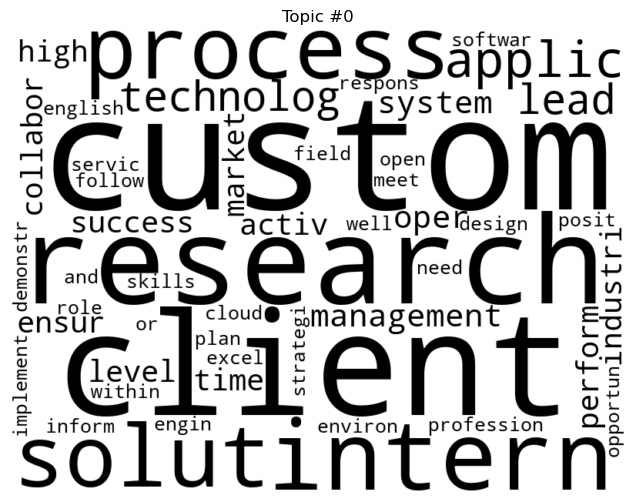

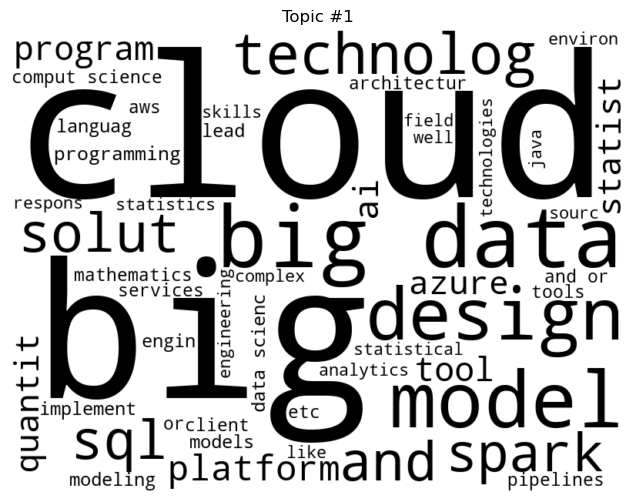

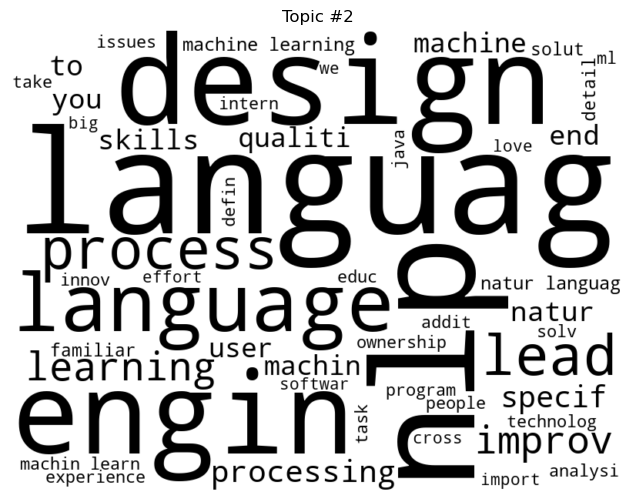

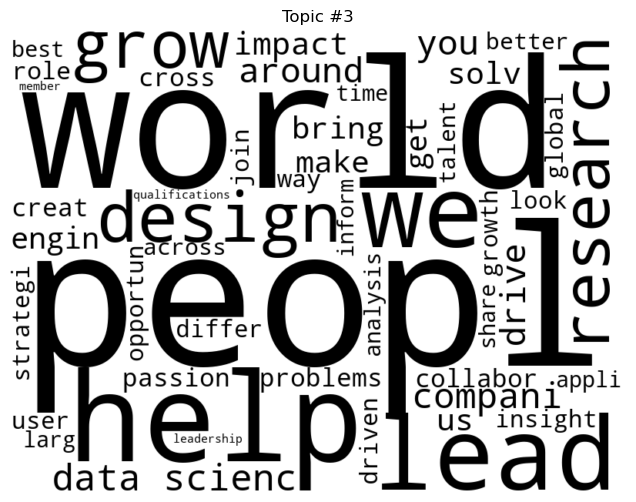

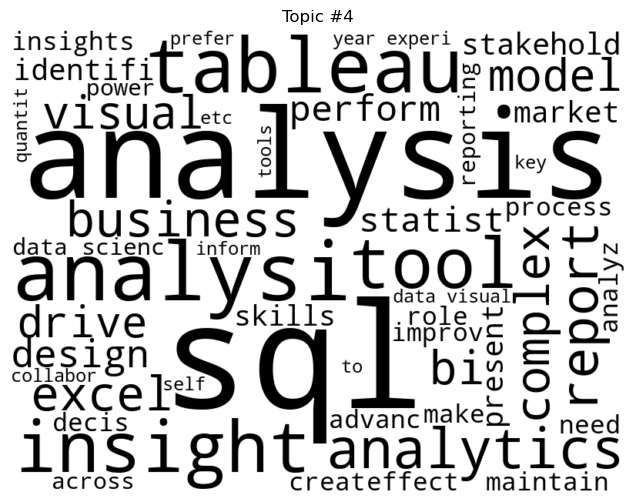

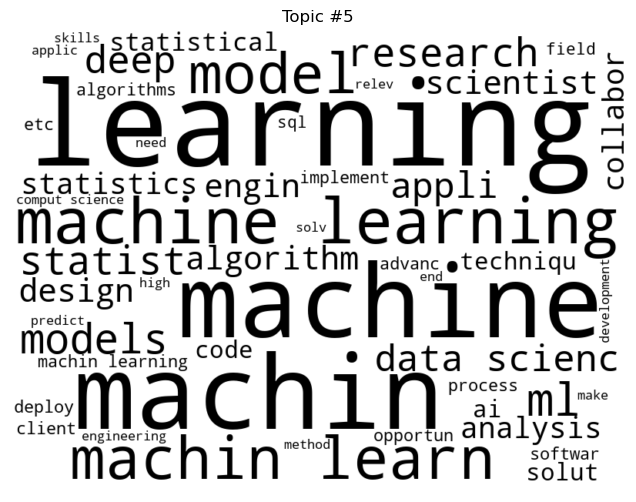

In [67]:
def generate_wordclouds(topics, dictionary):
    for topic_num, topic_words in topics:
        word_freq = dict(topic_words)
        wordcloud = WordCloud(
            width = 800,
            height = 600,
            background_color ='white',
            color_func=lambda *args, **kwargs: "black", # Ensures words are in black
            min_font_size = 10).generate_from_frequencies(word_freq)
        
        plt.figure(figsize = (8, 6), facecolor = None)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Topic #{topic_num}')
        plt.show()

# Generate word clouds for each topic
generate_wordclouds(topics, lda_model.id2word)

In [68]:
# Function to get the most probable topic for a document
def get_most_probable_topic(lda_model, document):
    topics = lda_model.get_document_topics(document, minimum_probability=0.2)
    if topics:
        return max(topics, key=lambda x: x[1])[0]
    else:
        return np.nan

# Apply the function to each document in the corpus
df_new['Cluster_job_title'] = [get_most_probable_topic(lda_model, doc) for doc in corpus]

# Map the topic numbers to your specified categories
topic_mapping = {
    0: 'Business Analyst',
    1: 'Software/Data Engineer',
    2: 'Machine Learning Engineer',
    3: 'Data Science Project Manager',
    4: 'Data Scientist/Analyst',
    5: 'Data Science Researcher'
}

df_new['Cluster_job_title'] = df_new['Cluster_job_title'].map(topic_mapping)

# Display or use df_new with the new 'Cluster_job_title' column
display(df_new[['job_title', 'Cluster_job_title']])

,job_title,Cluster_job_title
0,Student DATA,Business Analyst
1,Data Analyst - Student,Data Scientist/Analyst
2,DATA SCIENCE CONSULTANT LIMA,Software/Data Engineer
3,Senior Data Engineer - QuantumBlack,Software/Data Engineer
4,Data Scientist - QuantumBlack,Data Science Project Manager
...,...,...
2098,Manager of Data Science,Software/Data Engineer
2099,"Senior Analyst, Analytics - Amazon",Data Scientist/Analyst
2100,Strategy & Analytics AI and Data Strategy Cons...,Business Analyst
2101,Data Scientist/ Machine Learning Engineer - Re...,Data Science Researcher


### LSA

In [69]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=6)
U = svd.fit_transform(dtm_df)
Sigma = svd.singular_values_
VT = svd.components_


terms = vectorizer.get_feature_names_out()
for i, comp in enumerate(VT):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('learning', 0.1815282931813978), ('design', 0.18115336718870423), ('model', 0.1639403277435733), ('lead', 0.1352453555707921), ('sql', 0.13196845862176187)]
Topic 2:  [('learning', 0.4700899352237315), ('machin', 0.3452028234101298), ('machine', 0.33132472899217474), ('machine learning', 0.3247954941821572), ('machin learn', 0.27841524348171354)]
Topic 3:  [('cloud', 0.3710350004555152), ('technolog', 0.22328449744862544), ('solut', 0.19638268038860812), ('lead', 0.18620595939896206), ('custom', 0.16304643097903246)]
Topic 4:  [('research', 0.6056843637366331), ('peopl', 0.21307257609538544), ('world', 0.14050977135715037), ('lead', 0.12107248089457648), ('public', 0.10651480859060689)]
Topic 5:  [('lead', 0.24251174174393977), ('peopl', 0.23821787973137437), ('drive', 0.19605586675707296), ('help', 0.1683929683108423), ('we', 0.14376832280976778)]
Topic 6:  [('model', 0.4189715069392679), ('ai', 0.30310129090852084), ('lead', 0.23545562817679008), ('client', 0.231972491932

### Plotting LDA Topics

In [70]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis_data)

### Coherence of topics

In [71]:
from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-1.0114134862287252

In [72]:
# def compute_coherence(num_topics, corpus, dictionary):
#     lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)
#     coherence_model = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
#     coherence = coherence_model.get_coherence()
#     return coherence

# coherence_values = []


# min_topics = 2
# max_topics = 20
# step_size = 1

# # Iterate over different numbers of topics
# for num_topics in range(min_topics, max_topics + 1, step_size):
#     coherence = compute_coherence(num_topics, corpus, dictionary)
#     coherence_values.append(coherence)
#     print(f"Number of Topics: {num_topics}, Coherence: {coherence}")

# # Plotting coherence values vs. number of topics
# import matplotlib.pyplot as plt

# plt.plot(range(min_topics, max_topics + 1, step_size), coherence_values)
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score")
# plt.title("Coherence vs. Number of Topics")
# plt.xticks(range(min_topics, max_topics + 1, step_size))
# plt.grid(True)
# plt.show()


## Resumes

### Importing the data

In [75]:
data1 = pd.read_csv('/Users/user/Desktop/FINAL_INTRO_NLP/data/cv/Resume Screening.csv')
df_resume = pd.DataFrame(data1)

In [76]:
df_resume['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [77]:
df_resume

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


In [81]:
df_resume.shape

(543, 3)

In [82]:
print(df_resume['Resume'][20])

Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tableau. * Others: Regular Expression, HTML, CSS, Angular 6, Logstash, Kafka, Python Flask, Git, Docker, computer vision - Open CV and understanding of Deep learning.Education Details 

Data Science Assurance Associate 

Data Science Assurance Associate - Ernst & Young LLP
Skill Details 
JAVASCRIPT- Exprience - 24 months
jQuery- Exprience - 24 months
Python- Exprience - 24 monthsCompany Details 
company - Ernst & Young LLP
description - Fraud Investigations and Dispute Services   Assur

### Clustering categories in resumes

The resumes came with several different categories, some were not related to the Data Science industry, so were dropped.

In [78]:
values_to_keep = ['Data Science','Mechanical Engineer', 'Sales','Java Developer', 'Business Analyst','Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'Database','Blockchain', 'Testing']

In [79]:
df_resume['Category'] = df_resume['Category'].apply(lambda x: x if x in values_to_keep else 'NA')
df_resume = df_resume[df_resume['Category'] != 'NA']
print(df_resume['Category'].unique())
df_resume = df_resume.reset_index()

['Data Science' 'Mechanical Engineer' 'Sales' 'Java Developer'
 'Business Analyst' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'Database' 'Blockchain'
 'Testing']


The remaining were clustered based on the similarity between the avialable categories.

In [83]:
df_resume['Category'] = df_resume['Category'].apply(lambda x: x if 'Dev' not in x else 'Software Developer')
df_resume['Category'] = df_resume['Category'].apply(lambda x: x if 'Engineer' not in x else 'Engineer')
df_resume['Category'] = df_resume['Category'].apply(lambda x: x if x != 'Database' else 'Data Engineer')


In [85]:
df_resume['Category'].unique()

array(['Data Science', 'Engineer', 'Sales', 'Software Developer',
       'Business Analyst', 'Operations Manager', 'Data Engineer',
       'Blockchain', 'Testing'], dtype=object)

### Creating ID column

In [84]:
df_new['id'] = np.arange(0,len(df_new), 1)
df_resume['id'] = np.arange(0,len(df_resume), 1)


## Preprocessing

In [86]:
# df['processed_text'] = df['description'].apply(lambda x: ' '.join(abbr_or_lower(word) for word in x.split()))
# Remove stopwords
stop_words = set(stopwords.words('english'))
df_resume['processed_resume'] = df_resume['Resume'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Apply stemming
stemmer = PorterStemmer()
df_resume['processed_resume'] = df_resume['processed_resume'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

print(df_resume['processed_resume'])

0      skill * program languages: python (pandas, num...
1      educ detail may 2013 may 2017 b.e uit-rgpv dat...
2      area interest deep learning, control system de...
3      skill â¢ r â¢ python â¢ sap hana â¢ tablea...
4      educ detail mca ymcaust, faridabad, haryana da...
                             ...                        
538    comput skills: â¢ profici ms offic (word, bas...
539    â willing accept challenges. â posit think...
540    person skill â¢ quick learner, â¢ eager lear...
541    comput skill & softwar knowledg ms-power point...
542    skill set os window xp/7/8/8.1/10 databas mysq...
Name: processed_resume, Length: 543, dtype: object


## Matching Resumes

### Document Term Matrix

Fitting a new count vectorizer using job postings. Job postings were used as those will be the reference for all the required skills. Unnecessary information (tokens) in the resumes that are not mentioned in any of the job postings will not appear in the matrix.

In [91]:
# Create document term matrix using CountVectorizer

pd.set_option('display.max_columns', None)
cv_final = CountVectorizer(ngram_range = (1,2), min_df=0.075, max_df=0.40)
cv_final.fit(df_new['combined_text'])

X_jobs = cv_final.transform(df_new['combined_text'])
vectorized_jobs=X_jobs.todense()
print("Document term matrix has size:", vectorized_jobs.shape)
X_resumes = cv_final.transform(df_resume['processed_resume'])
vectorized_resumes=X_resumes.todense()
print("Document term matrix has size:", vectorized_resumes.shape)

Document term matrix has size: (1204, 480)
Document term matrix has size: (543, 480)


In [92]:
term_frequencies = np.sum(vectorized_jobs, axis=0).A1

# Sort frequencies and get sorted indices
sorted_indices = np.argsort(term_frequencies)[::-1]
sorted_frequencies = term_frequencies[list(sorted_indices)]

# Generate Term IDs (1-based indexing for better readability)
term_ids = np.arange(1, len(sorted_frequencies) + 1)

# Find the maximum value in the sorted frequencies
max_term_frequency = np.max(sorted_frequencies)
print("Max term frequency is", max_term_frequency)

# Get the feature names from the count vectorizer
feature_names = cv_final.get_feature_names_out()

# Now use sorted_indices to get the top terms
top_indices = sorted_indices[:5]  # Get the indices for the top 5 terms
top_terms = feature_names[top_indices]  # Get the corresponding feature names

# Now print out the top terms with their frequencies
for term, freq in zip(top_terms, sorted_frequencies[:5]):
    print(f"Term: {term}, Frequency: {freq}")


Max term frequency is 1252
Term: design, Frequency: 1252
Term: learning, Frequency: 1232
Term: model, Frequency: 1160
Term: sql, Frequency: 1015
Term: research, Frequency: 974


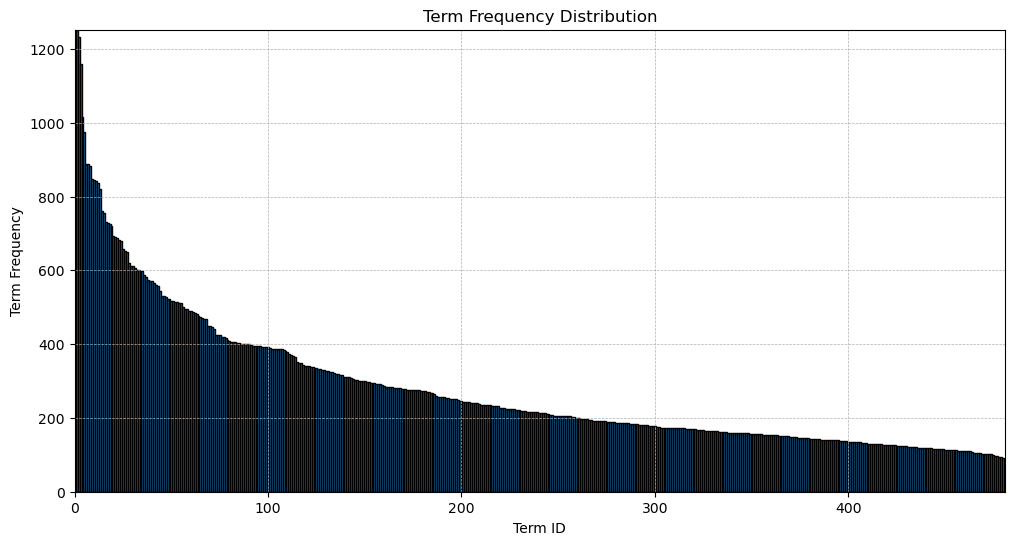

In [93]:
# Plotting with adjusted y-axis limits
plt.figure(figsize=(12, 6))
plt.bar(term_ids, sorted_frequencies, width=1.0, edgecolor='black')

# Set the y-axis and x-axis limits to start at 0 and end at the maximum
plt.ylim(0, max_term_frequency)
plt.xlim(left=0, right=len(term_ids)+1) 

# Improve the appearance
plt.title('Term Frequency Distribution')
plt.xlabel('Term ID')
plt.ylabel('Term Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.axhline(y=0, color='black', linewidth=1)

plt.show()

### Cosine Similarity Matching

In [94]:
# Function to compute cosine similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2.T)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    # Set norms to 1 if they are 0 to avoid division by zero
    if norm_vec1 == 0:
        norm_vec1 = 1
    if norm_vec2 == 0:
        norm_vec2 = 1
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity


Two slightly different approaches were used ot match candidates with job postings. 

The first one was to match the resume with every job posting and to store the 10 job cluster that held the highest values for cosine similarity and then take the mode of the one appearing the most as follows.

### Matching

In [96]:
# Initialize a dictionary to store the top 10 matches for each resume
matching_dictionary = {}

# Iterate through each resume and find the top 10 matches
for resume_id, resume_vector in enumerate(vectorized_resumes):
    similarities = {}
    top_matches = []
    for job_id, job_vector in enumerate(vectorized_jobs):
        similarity = float(cosine_similarity(resume_vector, job_vector))
        # Sort the dictionary based on values in ascending order
        if len(similarities)<10:
            similarities[job_id]=similarity
        elif similarity>next(iter(similarities.values())):
            first_key = next(iter(similarities))
            similarities[job_id] = similarity
            del similarities[first_key]
        similarities = dict(sorted(similarities.items(), key=lambda item: item[1]))
    # top_matches = similarities[-10:][::-1]  # Get indices of top 10 matches
    matching_dictionary[resume_id] = similarities

# Print or use the matching_dictionary as needed
print(matching_dictionary)

{0: {1145: 0.33999746763363875, 919: 0.3501416916271283, 192: 0.35293917216413023, 610: 0.35293917216413023, 744: 0.3617115493561753, 1009: 0.37165517655690056, 359: 0.3829420533322957, 418: 0.3893876605233235, 212: 0.40188636064756417, 764: 0.42048058881149314}, 1: {1086: 0.3015113445777636, 771: 0.31480768615064225, 874: 0.31553686940553305, 866: 0.31900455754433504, 290: 0.3248255502886646, 376: 0.32603355365661163, 830: 0.3302891295379081, 236: 0.3606069497894913, 1087: 0.3743681545638132, 340: 0.42640143271122083}, 2: {876: 0.2960721705238947, 648: 0.29903264203004387, 1091: 0.29903264203004387, 976: 0.31487746884583284, 96: 0.3149996923832631, 168: 0.3149996923832631, 483: 0.3149996923832631, 212: 0.32685408695247764, 898: 0.3483306533742698, 431: 0.3803873470057303}, 3: {486: 0.393825315761173, 650: 0.393825315761173, 691: 0.393825315761173, 1093: 0.393825315761173, 359: 0.4070119054613122, 364: 0.40764642782743465, 418: 0.4103082572953402, 69: 0.43739963679397226, 197: 0.437399

In [97]:
# Create a DataFrame to store the results
columns = [f"Match_{i+1}" for i in range(10)]
result_df = pd.DataFrame(columns=columns)

# Iterate through each resume in df_resumes and extract the top 10 job titles
for resume_id, matches in matching_dictionary.items():
    job_ids = list(matches.keys())
    job_titles = df_new.loc[df_new['id'].isin(job_ids), 'Cluster_job_title'].tolist()
    result_df.loc[resume_id] = job_titles

# Concatenate the result_df with df_resumes
result_df = pd.concat([df_resume, result_df], axis=1)

# Function to find the most common element in a list
def most_common(lst):
    data = Counter(lst)
    return max(lst, key=data.get)

# Add 'Predicted_job' column based on the most common job title in each row
result_df['Predicted_job'] = result_df.apply(lambda row: most_common(row), axis=1)
# Display or use result_df as needed
result_df=result_df.drop(columns=columns, axis = 1)
display(result_df)

,index,Category,Resume,id,processed_resume,Predicted_job
0,0,Data Science,Skills * Programming Languages: Python (pandas...,0,"skill * program languages: python (pandas, num...",Data Science Researcher
1,1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,1,educ detail may 2013 may 2017 b.e uit-rgpv dat...,Data Science Researcher
2,2,Data Science,"Areas of Interest Deep Learning, Control Syste...",2,"area interest deep learning, control system de...",Data Science Researcher
3,3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,3,skill â¢ r â¢ python â¢ sap hana â¢ tablea...,Data Scientist/Analyst
4,4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",4,"educ detail mca ymcaust, faridabad, haryana da...",Machine Learning Engineer
...,...,...,...,...,...,...
538,957,Testing,Computer Skills: â¢ Proficient in MS office (...,538,"comput skills: â¢ profici ms offic (word, bas...",Data Science Project Manager
539,958,Testing,â Willingness to accept the challenges. â ...,539,â willing accept challenges. â posit think...,Business Analyst
540,959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",540,"person skill â¢ quick learner, â¢ eager lear...",Business Analyst
541,960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,541,comput skill & softwar knowledg ms-power point...,Software/Data Engineer


The second approach was to compute average cosine similarity between each job cluster and the resume and then picking the cluster which held the highest cosine similarity as follows. 

# DROP NANs FROM THE RESULTING DATAFRAME

In [98]:
# Initialize dictionaries to store the similarity scores and average similarity for each resume and cluster
similarity_scores_dictionary = {}
average_similarity_dictionary = {}

# Iterate through each resume and find the similarity scores for each cluster
for resume_id, resume_vector in enumerate(vectorized_resumes):
    cluster_similarities = {cluster: [] for cluster in df_new['Cluster_job_title'].unique()}
    
    for job_id, job_vector in enumerate(vectorized_jobs):
        similarity = float(cosine_similarity(resume_vector, job_vector))
        cluster = df_new.loc[df_new['id'] == job_id, 'Cluster_job_title'].iloc[0]
        cluster_similarities[cluster].append(similarity)
    
    # Store the similarity scores in the dictionary
    similarity_scores_dictionary[resume_id] = cluster_similarities

    # Compute the average similarity for each cluster
    average_similarity = {f"{cluster}": np.mean(similarities) for cluster, similarities in cluster_similarities.items()}
    
    # Store the results in the dictionary
    average_similarity_dictionary[resume_id] = average_similarity
# Create DataFrames for average similarity and similarity scores
average_similarity_df = pd.DataFrame(average_similarity_dictionary).T

# Add columns to the existing DataFrame
df_result = pd.concat([result_df, average_similarity_df], axis=1)

# Add a column for the predicted cluster based on the highest average similarity
df_result['Predicted_job_cluster'] = df_result.loc[:, average_similarity_df.columns].idxmax(axis=1)

# Display or use df_result as needed
display(df_result)


,index,Category,Resume,id,processed_resume,Predicted_job,Business Analyst,Data Scientist/Analyst,Software/Data Engineer,Data Science Project Manager,Data Science Researcher,Machine Learning Engineer,nan,Predicted_job_cluster
0,0,Data Science,Skills * Programming Languages: Python (pandas...,0,"skill * program languages: python (pandas, num...",Data Science Researcher,0.156822,0.225211,0.195606,0.127453,0.205635,0.161153,0.0,Data Scientist/Analyst
1,1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,1,educ detail may 2013 may 2017 b.e uit-rgpv dat...,Data Science Researcher,0.065662,0.088196,0.102444,0.077505,0.200501,0.139415,0.0,Data Science Researcher
2,2,Data Science,"Areas of Interest Deep Learning, Control Syste...",2,"area interest deep learning, control system de...",Data Science Researcher,0.139714,0.156478,0.160538,0.133707,0.204019,0.203095,0.0,Data Science Researcher
3,3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,3,skill â¢ r â¢ python â¢ sap hana â¢ tablea...,Data Scientist/Analyst,0.152567,0.254047,0.193183,0.132677,0.194961,0.147265,0.0,Data Scientist/Analyst
4,4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",4,"educ detail mca ymcaust, faridabad, haryana da...",Machine Learning Engineer,0.049111,0.068811,0.047509,0.047102,0.052911,0.097606,0.0,Machine Learning Engineer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,957,Testing,Computer Skills: â¢ Proficient in MS office (...,538,"comput skills: â¢ profici ms offic (word, bas...",Data Science Project Manager,0.075367,0.083902,0.065251,0.055517,0.066474,0.092374,0.0,Machine Learning Engineer
539,958,Testing,â Willingness to accept the challenges. â ...,539,â willing accept challenges. â posit think...,Business Analyst,0.135690,0.121604,0.108522,0.094859,0.103185,0.179388,0.0,Machine Learning Engineer
540,959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",540,"person skill â¢ quick learner, â¢ eager lear...",Business Analyst,0.091809,0.089590,0.076803,0.067696,0.072367,0.075223,0.0,Business Analyst
541,960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,541,comput skill & softwar knowledg ms-power point...,Software/Data Engineer,0.086675,0.074012,0.098801,0.071297,0.079730,0.179358,0.0,Machine Learning Engineer


### Required Skills per job

In [99]:
df_new['Cluster_job_title'].unique()

array(['Business Analyst', 'Data Scientist/Analyst',
       'Software/Data Engineer', 'Data Science Project Manager',
       'Data Science Researcher', 'Machine Learning Engineer', nan],
      dtype=object)

In [101]:
df_new = df_new[~df_new['Cluster_job_title'].isna()]

In [102]:
# Initialize dictionaries to store the top 10 hard and soft skills for each cluster
top_hard_skills_dict = {}
top_soft_skills_dict = {}

# Iterate through each cluster
for cluster in df_new['Cluster_job_title'].unique():
    # Filter data for the current cluster
    cluster_data = df_new[df_new['Cluster_job_title'] == cluster]
    # display(cluster_data)
    # Create a TF-IDF vectorizer for hard skills
    vectorizer_hard = TfidfVectorizer(stop_words='english', min_df=0.07)
    tfidf_matrix_hard = vectorizer_hard.fit_transform(cluster_data['hard_skills'])
    feature_names_hard = np.array(vectorizer_hard.get_feature_names_out())
    total_tfidf_scores_hard = np.sum(tfidf_matrix_hard, axis=0)
    top_indices_hard = total_tfidf_scores_hard.argsort()[0, -20:][::-1]
    top_hard_skills = feature_names_hard[top_indices_hard]
    top_hard_skills_dict[cluster] = top_hard_skills

    # Create a TF-IDF vectorizer for soft skills
    vectorizer_soft = TfidfVectorizer(stop_words='english', min_df=0.05)
    tfidf_matrix_soft = vectorizer_soft.fit_transform(cluster_data['soft_skills'])
    feature_names_soft = np.array(vectorizer_soft.get_feature_names_out())
    total_tfidf_scores_soft = np.sum(tfidf_matrix_soft, axis=0)
    top_indices_soft = total_tfidf_scores_soft.argsort()[0, -20:][::-1]
    top_soft_skills = feature_names_soft[top_indices_soft]
    top_soft_skills_dict[cluster] = top_soft_skills

# Create new columns 'job_hard_skills' and 'job_soft_skills' in df_new
df_result['job_hard_skills'] = df_result['Predicted_job_cluster'].map(top_hard_skills_dict)
df_result['job_soft_skills'] = df_result['Predicted_job_cluster'].map(top_soft_skills_dict)

# Display df_new with the new columns
display(df_result[['Predicted_job_cluster', 'job_hard_skills', 'job_soft_skills']])


,Predicted_job_cluster,job_hard_skills,job_soft_skills
0,Data Scientist/Analyst,"[[visualization, modeling, quantitative, power...","[[paced, skills, attention, fast, present, lea..."
1,Data Science Researcher,"[[pytorch, processing, spark, cloud, intellige...","[[ml, presentation, paced, solving, technologi..."
2,Data Science Researcher,"[[pytorch, processing, spark, cloud, intellige...","[[ml, presentation, paced, solving, technologi..."
3,Data Scientist/Analyst,"[[visualization, modeling, quantitative, power...","[[paced, skills, attention, fast, present, lea..."
4,Machine Learning Engineer,"[[ops, language, natural, python, curation, le...","[[thinking, critical, self, intel, assist, bui..."
...,...,...,...
538,Machine Learning Engineer,"[[ops, language, natural, python, curation, le...","[[thinking, critical, self, intel, assist, bui..."
539,Machine Learning Engineer,"[[ops, language, natural, python, curation, le...","[[thinking, critical, self, intel, assist, bui..."
540,Business Analyst,"[[sql, development, aws, business, machine, ag...","[[ideas, data, attention, critical, presentati..."
541,Machine Learning Engineer,"[[ops, language, natural, python, curation, le...","[[thinking, critical, self, intel, assist, bui..."


# TODO:

- Stuff written in notebook

JOB POSTINGS:
- add other datasets for jobs
- more eda, analyze the data
- find the right amount of topics and the correct name for each topic
- Check again the matcher for job descriptions to isolate the information relevant to the job -> this should improve the LDA (did a little bit adding some words to matcher and adding the skills to the text)
- Find a good way to test the results (NOW THEY ARE NOT ACCURATE)

RESUMES:
- improve the parsing and preprocessing of the curriculums (https://www.kaggle.com/code/valivar/resume-parsing-with-nlp-ml-feb-hotel)
- add other datasets
- eda



# Additional Resources

### Resume parser

In [104]:
nlp = spacy.load('en_core_web_sm')


#Extracting text from DOCX
def extract_text_from_docx(docx_path):
    txt = docx2txt.process(docx_path)
    if txt:
        return txt.replace('\t', ' ')
    return None

## Extracting text from PDF
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)

#================Extracting person's name==============================================

def extract_names(txt):
    person_names = []
    for sent in nltk.sent_tokenize(txt):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label') and chunk.label() == 'PERSON':
                person_names.append(
                    ' '.join(chunk_leave[0] for chunk_leave in chunk.leaves())
                )
    return person_names[0]

#========================Extracting phone number========================================== 
PHONE_REG = re.compile(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]')
 
def extract_phone_number(resume_text):
    phone = re.findall(PHONE_REG, resume_text)
 
    if phone:
        number = ''.join(phone[0])
 
        if resume_text.find(number)  >= 0 and len(number) < 16:
            return number
    return None

#========================Extracting email==========================================

EMAIL_REG = re.compile(r'[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+')
 
def extract_emails(resume_text):
    return re.findall(EMAIL_REG, resume_text)

#========================Extracting skills================================================
SKILLS_DB = [
    'andriod developer',
    'app developer',
    'Javascript',
    'Java',
    'machine learning',
    'data science',
    'python',
    'CSS',
    'doctor',
    'teacher',
    'web development',
    'communication',
    'team work',
]

def extract_skills(input_text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = nltk.tokenize.word_tokenize(input_text)
    
    # remove the stop words
    filtered_tokens = [w for w in word_tokens if w not in stop_words]
 
    # remove the punctuation
    filtered_tokens = [w for w in word_tokens if w.isalpha()]
    
    # generate bigrams and trigrams (such as artificial intelligence)
    bigrams_trigrams = list(map(' '.join, nltk.everygrams(filtered_tokens, 2, 3)))
 
    # we create a set to keep the results in.
    found_skills = set()

    # we search for each token in our skills database
    for token in filtered_tokens:
        if token.lower() in SKILLS_DB:
            found_skills.add(token)
 
    # we search for each bigram and trigram in our skills database
    for ngram in bigrams_trigrams:
        if ngram.lower() in SKILLS_DB:
            found_skills.add(ngram)
    return found_skills
#========================Extracting education=========================================

RESERVED_WORDS = [
    'school',
    'college',
    'university',
    'academy',
    'faculty',
    'degree',
    'institute',]
 
def extract_education(input_text):
    organizations = []
 
    # first get all the organization names using nltk
    for sent in nltk.sent_tokenize(input_text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label') and chunk.label() == 'ORGANIZATION':
                organizations.append(' '.join(c[0] for c in chunk.leaves()))
 
    # we search for each bigram and trigram for reserved words
    # (college, university etc...)
    education = set()
    for org in organizations:
        for word in RESERVED_WORDS:
            if org.lower().find(word) >= 0:
                education.add(org)
 
    return education 
#=====================parse resume========================================================
def parse_resume(resume_text, output_file_path):
    name = extract_names(resume_text)
    email = extract_emails(resume_text)
    phone = extract_phone_number(resume_text)
    skills = extract_skills(resume_text)
    education = extract_education(resume_text)
    
 # Replace empty lists with a single empty string
    name = name or ['']
    email = email or ['']
    phone = phone or ['']
    skills = skills or ['']
    education = education or ['']
    info = {
        "Name": name,
        "Email": email,
        "Phone": phone,
        "Skills": skills,
    }
    print (info)
    with open(output_file_path, 'a') as f:
        f.write(tabulate(info, headers="keys"))
        f.write("\n\n")
    
if __name__ == '__main__':
    directory = '/kaggle/input/resume-dataset/Resumes/'
    for filename in os.listdir(directory):
        output_file_path = '/kaggle/working/output.txt'
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and file_path.endswith('.pdf'):
            resume_text = extract_text_from_pdf(file_path)
            print('File_name:', filename)
            parse_resume(resume_text,output_file_path)
        elif os.path.isfile(file_path) and file_path.endswith('.docx'):
            resume_text = extract_text_from_docx(file_path)
            print('-------------File_name:-------------', filename)
            parse_resume(resume_text ,output_file_path)
        else:
            print('Unsupported File Format:', filename)
        continue

### Dictionaries (not really good)

In [ ]:
education_vocabulary = [
    "degree",
    "bachelor's degree",
    "data science",
    "computer science",
    "economics",
    "statistics",
    "mathematics",
    "maths",
    "physics",
    "engineering",
    "computer engineering",
    "business analytics",
    "bachelor's degree in data science",
    "bachelor's degree in computer science",
    "bachelor's degree in economics",
    "bachelor's degree in artificial intelligence",
    "bachelor's degree in machine learning",
    "bachelor's degree in statistics",
    "bachelor's degree in mathematics",
    "bachelor's degree in information technology",
    "bachelor's degree in computer engineering",
    "bachelor's degree in business analytics",
    "master's degree in data science",
    "master's degree in computer science",
    "master's degree in economics",
    "master's degree in artificial intelligence",
    "master's degree in machine learning",
    "master's degree in statistics",
    "master's degree in mathematics",
    "master's degree in business analytics",
    "phd",
    "ph.d.",
    "ph.d. in data science",
    "ph.d. in computer science",
    "ph.d. in economics",
    "ph.d. in artificial intelligence",
    "ph.d. in machine learning",
    "ph.d. in statistics",
    "ph.d. in mathematics",
    "ph.d. in business analytics",
    "certification in data science",
    "certification in machine learning",
    "certification in business analytics",
    "online courses in data science",
    "online courses in machine learning",
    "online courses in business analytics",
    "advanced statistics",
    "quantitative methods",
    "machine learning algorithms",
    "econometrics",
    "previous experience"
]


In [ ]:
hard_skills_vocabulary = [
    "python",
    "sql",
    "machine learning",
    "data analysis",
    "statistical analysis",
    "data visualization",
    "big data",
    "artificial intelligence",
    "natural language processing",
    "deep learning",
    "predictive modeling",
    "time series analysis",
    "algorithm development",
    "feature engineering",
    "regression analysis",
    "clustering",
    "classification",
    "dimensionality reduction",
    "data mining",
    "data warehousing",
    "etl (extract, transform, load)",
    "hadoop",
    "spark",
    "nosql databases",
    "cloud computing",
    "model deployment",
    "version control (e.g., git)",
    "python libraries (numpy, pandas, scikit-learn)",
    "tensorflow",
    "keras",
    "pytorch",
    "tableau",
    "power bi",
    "excel",
    "data cleaning",
    "feature selection",
    "model evaluation",
    "a/b testing",
    "databases (mysql, postgresql)",
    "data governance",
    "data security",
    "data privacy",
    "data ethics",
    "agile methodologies",
    "scrum",
    "git",
    "linux",
    "shell scripting",
    "database management",
    "api integration",
    "data modeling",
    "geospatial analysis",
    "network analysis",
    "text mining",
    "web scraping",
    "data wrangling",
    "time complexity analysis",
    "algorithm optimization",
    "data structures",
    "computer vision",
    "reinforcement learning",
    "blockchain",
    "internet of things (iot)",
    "cybersecurity",
    "quantum computing",
    "devops",
    "containerization (docker, kubernetes)",
    "web development",
    "mobile app development",
    "front-end development",
    "back-end development",
    "full stack development",
    "api development",
    "ui/ux design",
    "microservices architecture",
    "natural language generation",
    "automated testing",
    "continuous integration/continuous deployment (ci/cd)",
    "parallel computing",
    "high-performance computing",
    "virtualization",
    "data storage solutions",
    "data streaming",
    "data compression",
    "data encryption",
    "data backup and recovery",
    "blockchain development",
    "cloud security",
    "edge computing"
]


In [ ]:
soft_skills_vocabulary = [
    "communication skills",
    "problem-solving",
    "critical thinking",
    "adaptability",
    "teamwork",
    "analytical thinking",
    "time management",
    "leadership",
    "attention to detail",
    "innovation",
    "collaboration",
    "creativity",
    "self-motivation",
    "initiative",
    "results-oriented",
    "interpersonal skills",
    "emotional intelligence",
    "conflict resolution",
    "presentation skills",
    "stakeholder management",
    "negotiation",
    "influence",
    "project management",
    "client-focused",
    "customer service",
    "flexibility",
    "open-mindedness",
    "cultural sensitivity",
    "diversity and inclusion",
    "resilience",
    "organizational skills",
    "detail orientation",
    "agile mindset",
    "constructive feedback",
    "cross-functional collaboration",
    "strategic thinking",
    "advisory skills",
    "consulting",
    "ethical decision-making",
    "learning agility",
    "resourcefulness",
    "continuous learning",
    "curiosity",
    "empathy",
    "team building",
    "conflict management",
    "decision-making",
    "networking",
    "tactfulness"
]
